In [8]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

# 1.读取数据

In [22]:
# 拟合圆的函数
def fit_circle(x, y):
	"""拟合圆并计算曲率半径"""
	def residuals(params):
		x0, y0, R = params
		return np.sqrt((x - x0)**2 + (y - y0)**2) - R

	# 初始猜测值（圆心在路径中心附近，半径取平均距离）
	x0_guess = np.mean(x)
	y0_guess = np.mean(y)
	R_guess = np.mean(np.sqrt((x - x0_guess)**2 + (y - y0_guess)**2))
	
	# 使用最小二乘法拟合圆
	result = least_squares(residuals, [x0_guess, y0_guess, R_guess])
	 # 拟合圆的圆心坐标和半径
	x0, y0, radius = result.x
	
	# 计算每个点的角度（相对于圆心）
	angles = np.arctan2(y - y0, x - x0)
	
	# 计算角度差（弧长）
	angle_diff = np.diff(angles)  # 计算连续点之间的角度差
	arc_length = np.sum(np.abs(angle_diff)) * radius  # 弧长 = 半径 * 角度差之和
	return radius, arc_length  # 返回曲率半径和弧长

# 计算曲率、运动时间和夹角的函数
def calculate_curvature_and_angles(head_points, timestamps, stability_threshold=0.01):
	# 朝向方向
	head_dirs = np.diff(head_points, axis=0)  # 计算连续点之间的差值，代表朝向变化
	head_dirs = np.vstack([head_dirs, head_dirs[-1]])  # 补充最后一个方向，使得与head_points长度一致
	positions = head_points
	
	# 计算每50个连续点的运动曲率半径、时间、夹角
	window_size = 75
	window_interval = 5
	num_windows = (len(head_points)-window_size-1) // window_interval
	curvatures = []
	omegas = []
	angles = []
	velocity_fowards = []
	for i in range(num_windows):
		start_idx = i * window_interval
		end_idx = i * window_interval + window_size

		# 获取当前窗口的位置数据
		x = positions[start_idx:end_idx, 0]
		y = positions[start_idx:end_idx, 1]
		
		# 拟合曲率半径和弧长
		radius, arc_length = fit_circle(x, y)
		curvatures.append(radius)

		# 计算角速度（omega），即弧长除以半径和时间差
		omega = arc_length / radius / (timestamps[end_idx-1] - timestamps[start_idx])
		omegas.append(omega)
	
		# 计算夹角：朝向方向和切线方向的夹角
		# 计算路径切向方向：相邻两点之间的方向
		tangent_dirs = positions[start_idx + 1:end_idx + 1] - positions[start_idx:end_idx]  # 相邻点的差值
		tangent_angles = np.arctan2(tangent_dirs[:, 1], tangent_dirs[:, 0])  # 计算切线方向的角度
		
		# 计算朝向方向的角度
		head_angles = np.arctan2(head_dirs[start_idx:end_idx, 1], head_dirs[start_idx:end_idx, 0])  # 头部方向角度
		
		# 计算夹角：朝向方向和路径切线的夹角
		angle_differences = np.abs(tangent_angles - head_angles)  # 计算角度差
		angle_differences = np.minimum(angle_differences, 2 * np.pi - angle_differences)  # 夹角是小于180度的

		# 计算平均夹角
		angles.append(np.mean(angle_differences))
		velocity_fowards.append(omega * radius * np.cos(np.mean(angle_differences)))
	# 查找稳定阶段：通过检查曲率、角速度和夹角的变化来判断稳定阶段
	stable_velocity_fowards = []
	stable_curvatures = []
	stable_omegas = []
	stable_angles = []
	
	# 计算稳定阶段（即变化幅度小于某个阈值的段）
	for i in range(1, len(curvatures)):
		if abs(velocity_fowards[i] - velocity_fowards[i-1]) < stability_threshold :
			stable_velocity_fowards.append(velocity_fowards[i])
			stable_curvatures.append(curvatures[i])
			stable_omegas.append(omegas[i])
			stable_angles.append(angles[i])

	# 提取稳定阶段的平均值
	avg_stable_velocity_fowards = get_stable_value(np.array(stable_velocity_fowards), threshold=0.01, method="mean") if get_stable_value(np.array(stable_velocity_fowards), threshold=0.01, method="mean") else None
	avg_stable_curvatures = np.mean(stable_curvatures) if stable_curvatures else None
	avg_stable_omegas = np.mean(stable_omegas) if stable_omegas else None
	avg_stable_angles = np.mean(stable_angles) if stable_angles else None
	
	return avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards

def get_stable_value(data, threshold=0.01, method="mean"):
	"""
	提取数组的最终稳定值
	
	参数：
	data (numpy.ndarray): 输入的数据数组
	threshold (float): 变化阈值，用于判断数据是否稳定，默认0.01
	method (str): 提取稳定值的方法，"mean"为计算均值，"last"为取最后一个值，默认"mean"
	
	返回：
	stable_value (float): 最终稳定值
	"""
	# 计算数据的差分
	diff_data = np.abs(np.diff(data))  # 计算相邻元素的差值（绝对值）

	# 找出变化小于阈值的位置，表示系统已稳定
	stable_indices = np.where(diff_data < threshold)[0]  # 获取变化小于阈值的位置索引

	# 如果找到了稳定阶段
	if len(stable_indices) > 0:
		last_stable_index = stable_indices[-1]  # 最后一个稳定点的索引
		stable_segment = data[last_stable_index:]  # 提取稳定阶段的所有数据
		
		if method == "mean":
			stable_value = np.mean(stable_segment)  # 计算稳定阶段的平均值
		elif method == "last":
			stable_value = stable_segment[-1]  # 取稳定阶段的最后一个值
		else:
			raise ValueError("Invalid method! Use 'mean' or 'last'.")
	else:
		# 如果没有找到明显的稳定阶段，直接返回最后一个值
		stable_value = data[-1]
	
	return stable_value

['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/0-10-0.csv']


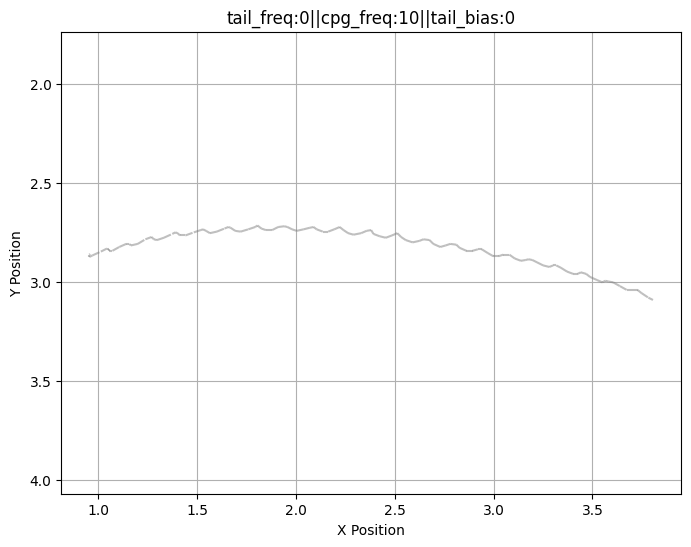

[np.float64(0.12448490969511854), np.float64(0.12669172047375205), np.float64(0.12696517259436801), np.float64(0.12577036311735673), np.float64(0.1324017779329964), np.float64(0.132939684639741), np.float64(0.12922579969391523), np.float64(0.14273631935449307), np.float64(0.13580290953457286), np.float64(0.13289826561374649), np.float64(0.144129058339529), np.float64(0.13753853332281774), np.float64(0.13645709831335504), np.float64(0.1430398691203279), np.float64(0.14229268067421083), np.float64(0.13698708793497208), np.float64(0.14305403784160256), np.float64(0.14591454875732593), np.float64(0.13894653697562007), np.float64(0.14280312125582367), np.float64(0.14755348972526947), np.float64(0.14061366480254672), np.float64(0.1405686063385059), np.float64(0.14606378109505846), np.float64(0.1428972193293238), np.float64(0.14066724048763596), np.float64(0.14747877470891166), np.float64(0.14329333727254528), np.float64(0.14314685390345755), np.float64(0.14641791434747675), np.float64(0.1451

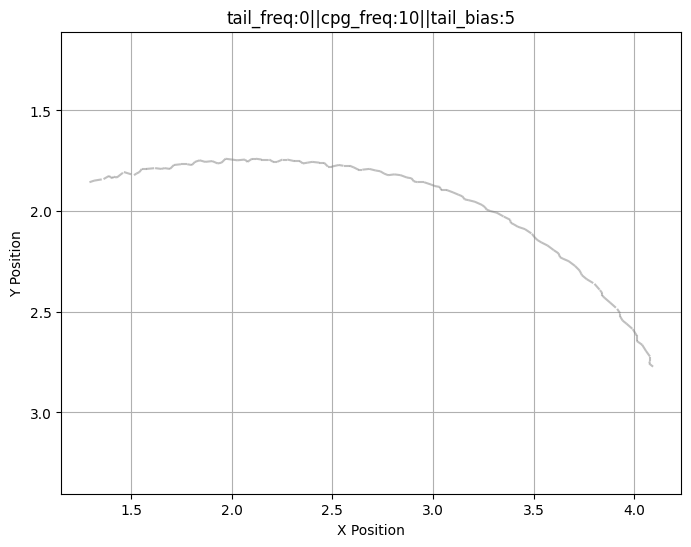

[np.float64(0.1440086742456205), np.float64(0.13328884265772645), np.float64(0.13621990411866075), np.float64(0.14294606467527615), np.float64(0.14002888466547572), np.float64(0.1344475288400535), np.float64(0.1405376352559339), np.float64(0.1425856369929102), np.float64(0.1382411784691489), np.float64(0.14044260158023156), np.float64(0.14344688841163405), np.float64(0.13821103751534308), np.float64(0.13899160115226014), np.float64(0.1431095369208509), np.float64(0.13921536316294064), np.float64(0.13934343544157696), np.float64(0.14642887281119088), np.float64(0.14153478356990656), np.float64(0.13740757656456), np.float64(0.14208472594361918), np.float64(0.14277009946208424), np.float64(0.13900304374228334), np.float64(0.14310871931095487), np.float64(0.14406174517756715), np.float64(0.13883443261913764), np.float64(0.14182380485496993), np.float64(0.1431179860826042), np.float64(0.13889718470372897), np.float64(0.13878017110881105), np.float64(0.14298996301912817), np.float64(0.139837

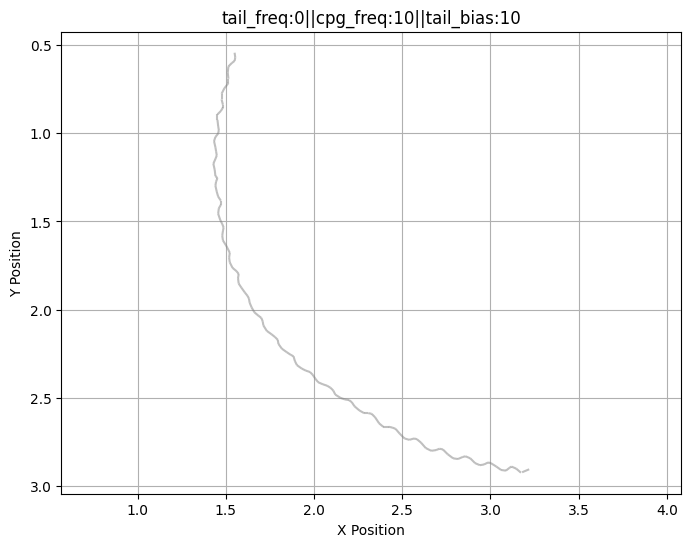

[np.float64(0.14765123646185668), np.float64(0.14058620557864096), np.float64(0.14159347609141032), np.float64(0.14877899968896854), np.float64(0.14628729819253122), np.float64(0.1440782500811721), np.float64(0.14926612149097895), np.float64(0.1503002853291494), np.float64(0.14816804813325254), np.float64(0.15043307149711338), np.float64(0.152192057853846), np.float64(0.14526004850778107), np.float64(0.14722124962351021), np.float64(0.15110580909927307), np.float64(0.14602952467443375), np.float64(0.14320449543711325), np.float64(0.1474961791220949), np.float64(0.14397029216108512), np.float64(0.14127877627105576), np.float64(0.14396133816421938), np.float64(0.1439497779647949), np.float64(0.1385812746439546), np.float64(0.14227724399565847), np.float64(0.14317749272131253), np.float64(0.13737999766157827), np.float64(0.14074265483582268), np.float64(0.14187927539302259), np.float64(0.13712486082654893), np.float64(0.14013518922803284), np.float64(0.14211777530383948), np.float64(0.140

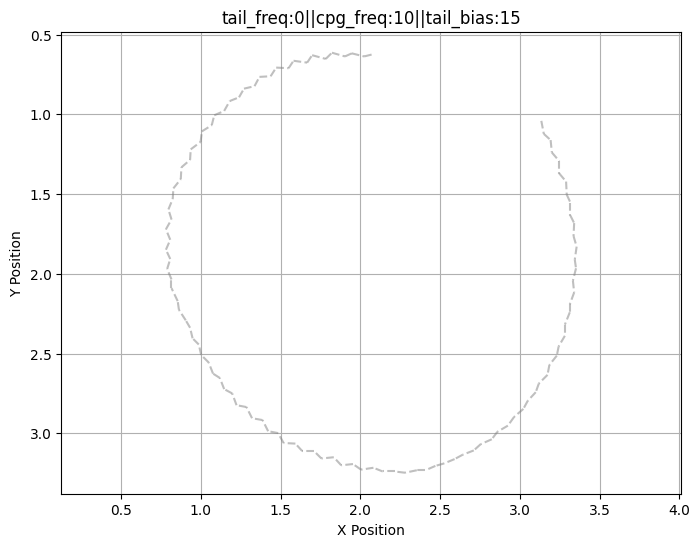

[np.float64(0.13861455280232346), np.float64(0.13463310298766573), np.float64(0.13966617594270145), np.float64(0.14257536938857054), np.float64(0.1389283419311662), np.float64(0.14166066769611035), np.float64(0.14592703836981666), np.float64(0.1388470589958414), np.float64(0.1422443497766845), np.float64(0.14452413768635922), np.float64(0.1419103055556424), np.float64(0.14206998724960532), np.float64(0.14504515634358622), np.float64(0.1456827675620374), np.float64(0.14246543922315932), np.float64(0.14709790427552108), np.float64(0.14857622448215682), np.float64(0.14499595197363727), np.float64(0.14824546582435214), np.float64(0.14613534022590263), np.float64(0.14314674094238689), np.float64(0.14548056884363544), np.float64(0.14537777306824765), np.float64(0.14302585486710773), np.float64(0.14270046045153292), np.float64(0.14551646428436385), np.float64(0.14289316022476733), np.float64(0.1404465303751068), np.float64(0.1414729635110605), np.float64(0.1379428179454945), np.float64(0.1356

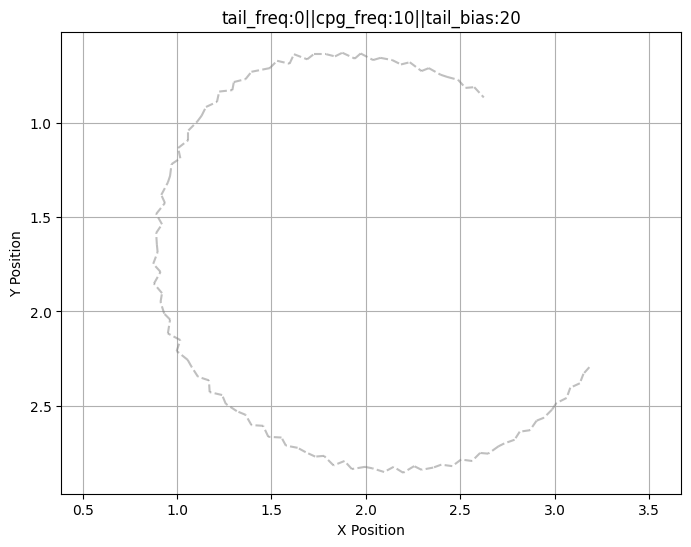

[np.float64(0.11748975506015193), np.float64(0.11849046878560925), np.float64(0.12154904818848594), np.float64(0.1187360471037331), np.float64(0.11724138094848215), np.float64(0.12159135052386032), np.float64(0.11793374016800244), np.float64(0.11724248732872271), np.float64(0.12149924957924814), np.float64(0.12021290286386184), np.float64(0.11654370416330616), np.float64(0.12080985535358794), np.float64(0.12076046889543168), np.float64(0.11672309090112627), np.float64(0.11971787482115899), np.float64(0.12271542353515735), np.float64(0.11853297582716901), np.float64(0.11849036536989102), np.float64(0.12474878610800623), np.float64(0.12107664391534145), np.float64(0.11892936763136241), np.float64(0.12519920807681453), np.float64(0.12450116206133163), np.float64(0.12037653300784983), np.float64(0.1252594477376195), np.float64(0.12659329085527976), np.float64(0.1222441172396724), np.float64(0.12591932658004562), np.float64(0.12716697704687402), np.float64(0.12371515275636344), np.float64(0

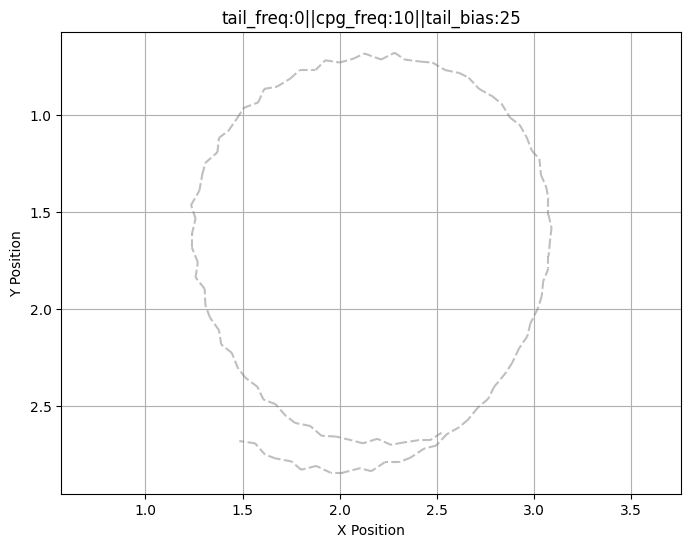

[np.float64(0.11368993096743903), np.float64(0.11679265550632502), np.float64(0.11536391649180497), np.float64(0.11500610798306664), np.float64(0.12034573433813009), np.float64(0.1167148288478329), np.float64(0.1148028576077282), np.float64(0.11858101997089267), np.float64(0.11818354031845922), np.float64(0.11484241284426526), np.float64(0.1175561896362511), np.float64(0.11909044891748115), np.float64(0.11582106348099794), np.float64(0.1166069510161571), np.float64(0.1195721102918428), np.float64(0.11729309931709073), np.float64(0.11483768834370843), np.float64(0.11531492509818553), np.float64(0.11818142195478017), np.float64(0.11322973188947956), np.float64(0.11661614845542305), np.float64(0.11956279408492004), np.float64(0.11489615336796533), np.float64(0.11494800896837974), np.float64(0.11963322899459232), np.float64(0.11827715280499831), np.float64(0.1161729344650277), np.float64(0.12036960303989645), np.float64(0.1203462785517188), np.float64(0.1172391903204172), np.float64(0.1213

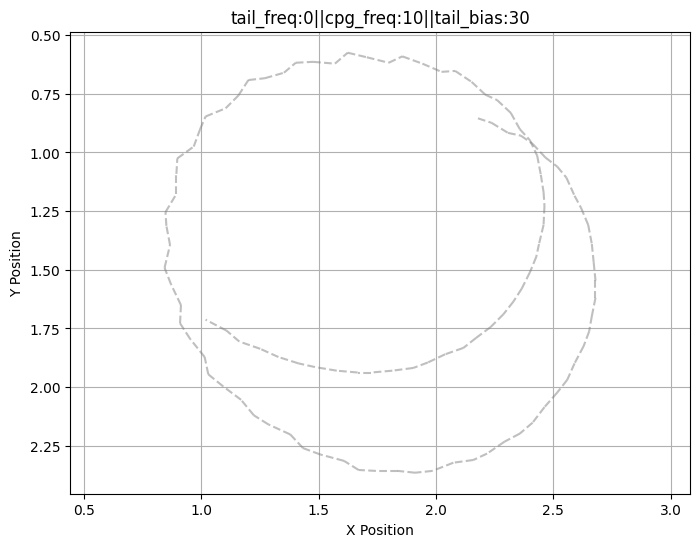

[np.float64(0.09954106288710574), np.float64(0.09577145526023849), np.float64(0.10112111911193208), np.float64(0.10283958128321967), np.float64(0.09690979834399523), np.float64(0.09962708803253223), np.float64(0.10569109995149797), np.float64(0.09979551988409924), np.float64(0.10238359409227651), np.float64(0.10706987980308705), np.float64(0.10250161299318522), np.float64(0.10234882434525247), np.float64(0.10791900650512037), np.float64(0.10489981737230292), np.float64(0.10456691586050271), np.float64(0.10706087867922126), np.float64(0.10721698125684197), np.float64(0.10450151283704553), np.float64(0.1081307210748427), np.float64(0.10788027537492992), np.float64(0.10651542652450285), np.float64(0.10717725113428926), np.float64(0.10893940161810911), np.float64(0.10625371849788383), np.float64(0.10767423506995995), np.float64(0.11012904363381354), np.float64(0.10748046392251566), np.float64(0.10986077126415186), np.float64(0.11288190070669248), np.float64(0.10820811511034033), np.float64

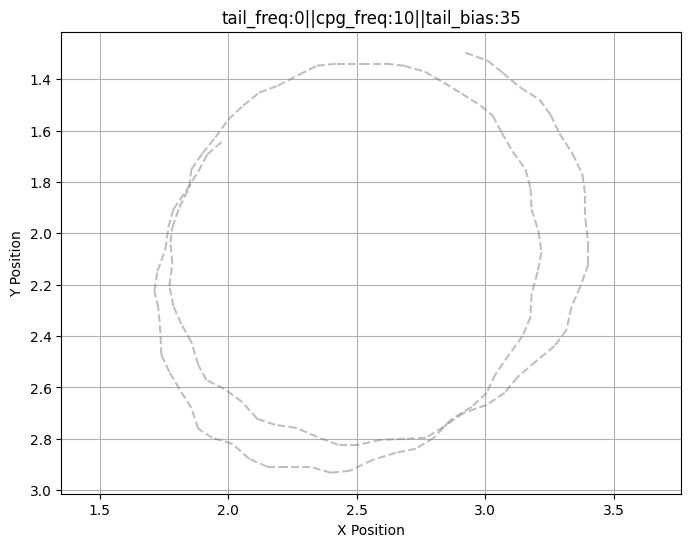

[np.float64(0.11497882734737722), np.float64(0.11597902414385587), np.float64(0.11641240749623193), np.float64(0.11480925333206862), np.float64(0.11681650329895747), np.float64(0.11911001027378919), np.float64(0.11519168645693653), np.float64(0.11728779568802475), np.float64(0.12226070558370092), np.float64(0.11974387728110088), np.float64(0.11802417744522739), np.float64(0.12239494959016554), np.float64(0.12372201155518425), np.float64(0.12010921414414494), np.float64(0.12211436761829497), np.float64(0.12724105693099214), np.float64(0.1228533518241778), np.float64(0.12239930492516021), np.float64(0.12440326817206396), np.float64(0.12249228101414057), np.float64(0.11990705475047843), np.float64(0.12356125660862692), np.float64(0.12333313488090938), np.float64(0.11918360423103228), np.float64(0.12149986418153987), np.float64(0.12429616257969105), np.float64(0.119661940001985), np.float64(0.11963768900540084), np.float64(0.1229538181217094), np.float64(0.1217857025286757), np.float64(0.1

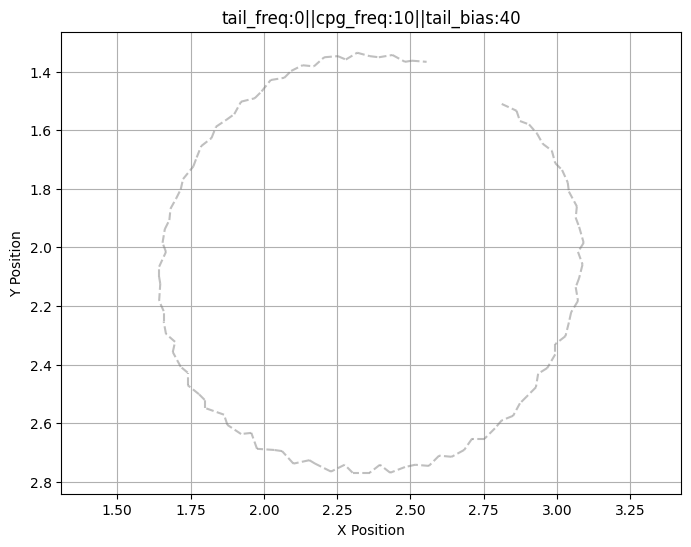

[np.float64(0.10203531414534554), np.float64(0.10044812044089306), np.float64(0.10365311413712217), np.float64(0.10380027199737879), np.float64(0.10331407942843059), np.float64(0.10424706053966551), np.float64(0.1070823387223379), np.float64(0.10492015144837184), np.float64(0.10613642338120297), np.float64(0.11055295022505691), np.float64(0.10842814748385272), np.float64(0.10715499925941896), np.float64(0.11265049483217897), np.float64(0.10985090231419742), np.float64(0.10808180968603054), np.float64(0.11282569983429948), np.float64(0.11276933032272009), np.float64(0.10844493987832009), np.float64(0.11155184539605112), np.float64(0.11322208394744782), np.float64(0.11016008275035007), np.float64(0.11147507070891353), np.float64(0.11377313585036734), np.float64(0.11134715949725765), np.float64(0.11135201748987807), np.float64(0.11620462877152149), np.float64(0.11292836364528654), np.float64(0.11326077790675662), np.float64(0.11725306733924863), np.float64(0.11556897689318862), np.float64

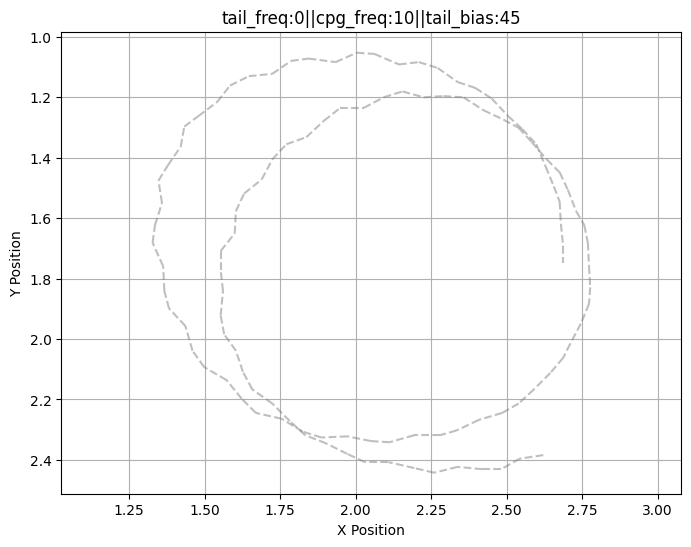

[np.float64(0.11329451812376874), np.float64(0.11052251037153274), np.float64(0.10986132575205503), np.float64(0.11453085841285349), np.float64(0.11213891695221737), np.float64(0.10988960006505633), np.float64(0.11513952980213771), np.float64(0.1148704023081529), np.float64(0.11072378869485264), np.float64(0.11407513529443307), np.float64(0.11637952680722873), np.float64(0.1121957109478704), np.float64(0.11235683782869867), np.float64(0.11571983014983134), np.float64(0.11227103628038307), np.float64(0.10978120974823312), np.float64(0.1145957099185424), np.float64(0.11241149344875596), np.float64(0.10903389195542423), np.float64(0.11038654865685223), np.float64(0.11173159989149645), np.float64(0.10969711040914701), np.float64(0.10993600690592222), np.float64(0.11252611519445829), np.float64(0.10816031626518259), np.float64(0.10421430911424337), np.float64(0.10911704381326033), np.float64(0.105138446254708), np.float64(0.7904238195540961), np.float64(0.8986928225325762), np.float64(0.819

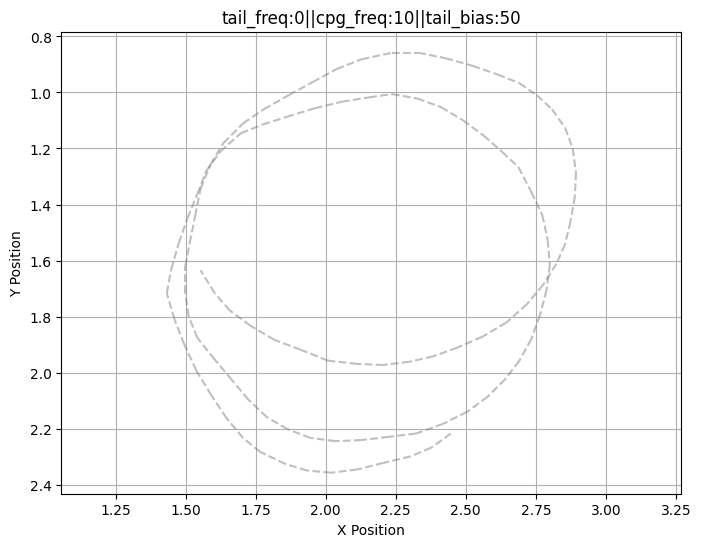

[np.float64(0.10389839055699115), np.float64(0.10120537916094484), np.float64(0.10501604244429477), np.float64(0.103404582408267), np.float64(0.10018257203171452), np.float64(0.10293106832225778), np.float64(0.10368141847055479), np.float64(0.09957473637283311), np.float64(0.09986999446815624), np.float64(0.10376167870936037), np.float64(0.0971471908949721), np.float64(0.0978412598746418), np.float64(0.10313055270845901), np.float64(0.09994148846274625), np.float64(0.1003211427685699), np.float64(0.10573208664332509), np.float64(0.1048705185118087), np.float64(0.1027850824207666), np.float64(0.10905787778338467), np.float64(0.10884707960206426), np.float64(0.10590479644696471), np.float64(0.11088878275363984), np.float64(0.11214266615618275), np.float64(0.10888022630610064), np.float64(0.11162756195567802), np.float64(0.11537920593798283), np.float64(0.11184971828970534), np.float64(0.11284580396027881), np.float64(0.11665381400524562), np.float64(1.1283014451659044), np.float64(1.0145

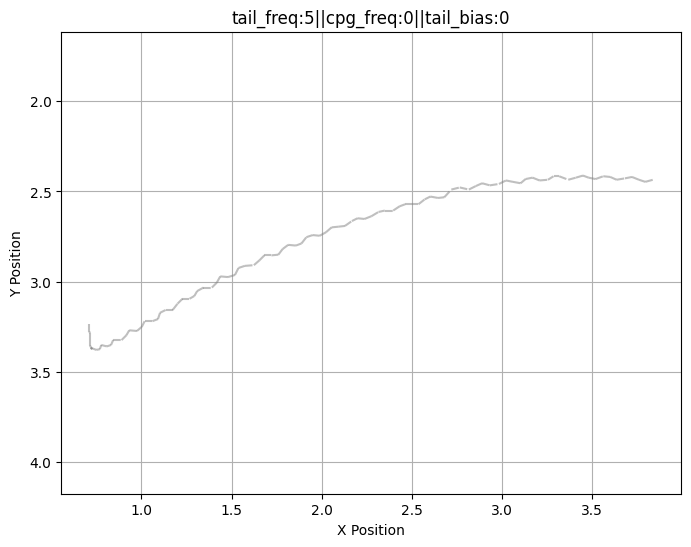

[np.float64(0.8572419325139622), np.float64(0.4824742790842726), np.float64(1.2642946929968693), np.float64(0.22074124032266046), np.float64(0.19152790587826915), np.float64(0.11496028815806458), np.float64(0.1822373930390828), np.float64(0.14770060421713632), np.float64(0.06063793471699067), np.float64(0.05589480652890534), np.float64(0.05581181609316215), np.float64(0.058737506849809086), np.float64(0.030101727561057272), np.float64(0.031022449909529775), np.float64(0.03199869956269943), np.float64(0.030236045069852713), np.float64(0.03120851678497189), np.float64(0.03363741332477058), np.float64(0.036712876512916534), np.float64(0.03642857691167154), np.float64(0.037836549821925594), np.float64(0.0399573319287175), np.float64(0.041399827238866156), np.float64(0.04207612128408344), np.float64(0.04418200343051452), np.float64(0.04440883206365393), np.float64(0.04421467190378977), np.float64(0.043801867687220185), np.float64(0.04531781039021613), np.float64(0.047653629391913324), np.fl

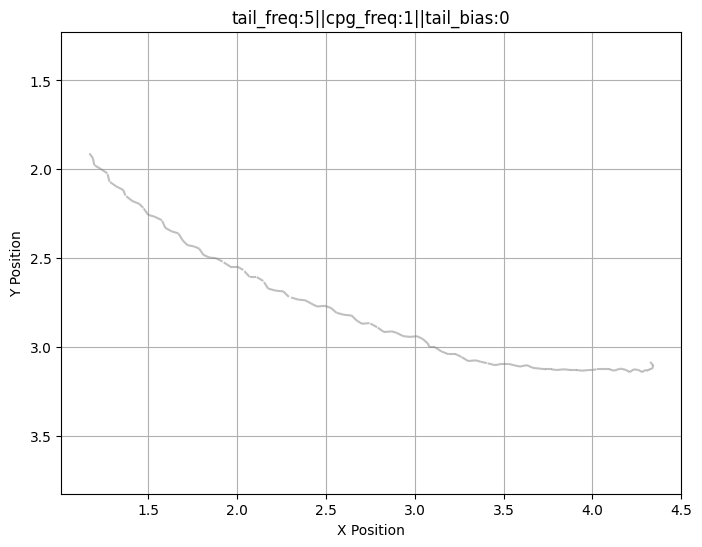

[np.float64(0.04200238155868248), np.float64(0.042989942145726025), np.float64(0.041766584717991995), np.float64(0.04121631986598803), np.float64(0.039320836380399564), np.float64(0.03819334271207262), np.float64(0.035874838654762584), np.float64(0.031026943752888225), np.float64(0.030014296547577528), np.float64(0.029793715638445385), np.float64(0.03175529414383781), np.float64(0.02972278522334249), np.float64(0.0331137632545723), np.float64(0.035110082385023576), np.float64(0.035833678727277996), np.float64(0.03632410606789086), np.float64(0.03633808490562441), np.float64(0.03739281482644729), np.float64(0.03831127140285774), np.float64(0.03855468369445206), np.float64(0.03957712668899096), np.float64(0.04073992390997397), np.float64(0.04231252990946201), np.float64(0.04379279312961304), np.float64(0.045114632011299866), np.float64(0.04668065930242888), np.float64(0.0475023644875344), np.float64(0.047142807031355594), np.float64(0.046520498334678015), np.float64(0.04698757716343686),

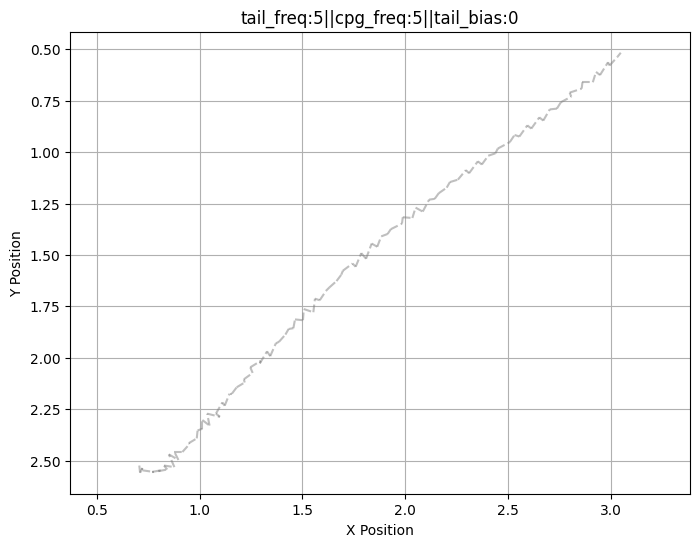

[np.float64(0.4451084237613425), np.float64(0.4765670216011733), np.float64(0.45159953509094336), np.float64(0.48079052316406345), np.float64(0.52063750051994), np.float64(0.5112190121791527), np.float64(0.4022188922384905), np.float64(0.3268499546168667), np.float64(0.24354253213189336), np.float64(0.34830821713613264), np.float64(0.5465950211540301), np.float64(0.5490216025094113), np.float64(0.4983279648145614), np.float64(0.47536436549008065), np.float64(0.3526673756591535), np.float64(0.2107527173179688), np.float64(0.4198589207812678), np.float64(0.4189884919332009), np.float64(0.4647093961125749), np.float64(0.36298261149485006), np.float64(0.35876348449651174), np.float64(0.40117994516022), np.float64(0.5221654656895485), np.float64(0.537175854213392), np.float64(0.5224431207350123), np.float64(0.3746551472338642), np.float64(0.39914197781971517), np.float64(0.2595709467012517), np.float64(0.2560436071327801), np.float64(0.2646231793844657), np.float64(0.2668103592176724), np.f

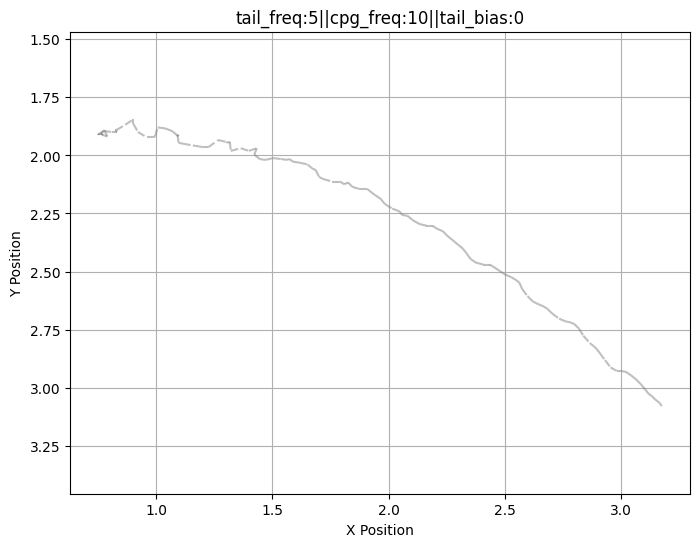

[np.float64(0.08295655402281626), np.float64(0.09486751036568003), np.float64(0.11343539785200561), np.float64(0.12090456702758835), np.float64(0.11943687041302599), np.float64(0.11864487965826885), np.float64(0.12074486609304061), np.float64(0.11896918257828691), np.float64(0.1250220234875095), np.float64(0.12872435264065676), np.float64(0.1316335344200018), np.float64(0.13662475144275424), np.float64(0.13014956632143201), np.float64(0.13478974134527627), np.float64(0.1436100411371905), np.float64(0.1347234383514125), np.float64(0.1345452226570457), np.float64(0.1414078261435054), np.float64(0.1326666639906306), np.float64(0.13461479126693313), np.float64(0.14638254639206016), np.float64(0.14097118753878288), np.float64(0.13827076834339685), np.float64(0.14572296001155025), np.float64(0.1436512240770709), np.float64(0.13994494253932668), np.float64(0.14101733120332963), np.float64(0.14447421005191716), np.float64(0.14128023918588625), np.float64(0.14399713683630413), np.float64(0.1487

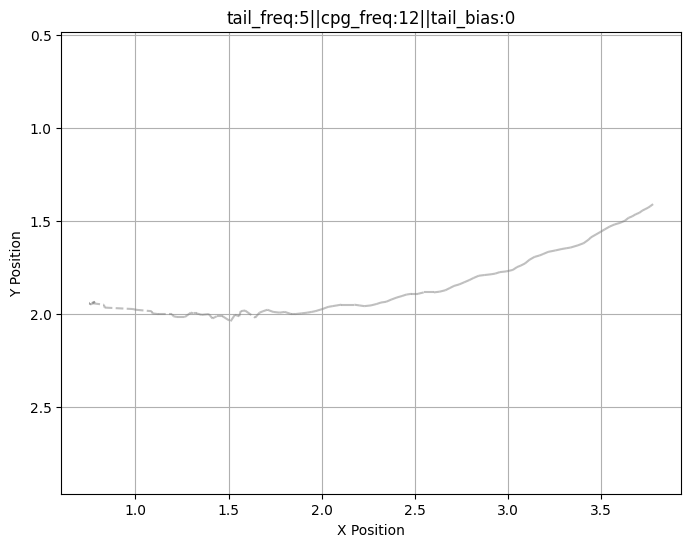

[np.float64(0.09942026508959127), np.float64(0.11900801867265008), np.float64(0.13290912597850693), np.float64(0.13894594746404024), np.float64(0.13882978270944873), np.float64(0.15370171332604687), np.float64(0.15042655548023212), np.float64(0.15641293615480073), np.float64(0.1480872668770094), np.float64(0.15526170535120148), np.float64(0.15000687761462525), np.float64(0.15455684274597253), np.float64(0.15675054189615964), np.float64(0.15255740740134233), np.float64(0.15867875983205526), np.float64(0.15592537166659268), np.float64(0.15743537465577234), np.float64(0.16372394070721438), np.float64(0.15885281548688296), np.float64(0.16127107949286884), np.float64(0.16244470368750039), np.float64(0.1591672929856307), np.float64(0.16308431084164104), np.float64(0.16012510094292012), np.float64(0.15869269538967798), np.float64(0.16285101682247852), np.float64(0.15864928848444484), np.float64(0.15966943802047487), np.float64(0.16001622362087975), np.float64(0.15833217845447298), np.float64(

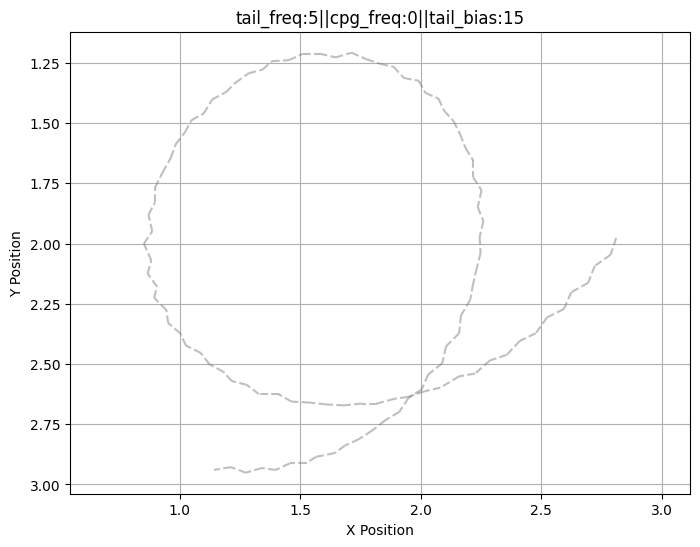

[np.float64(0.05877080253523953), np.float64(0.059520670034358666), np.float64(0.059605225729239555), np.float64(0.060071090718629275), np.float64(0.0602896744391135), np.float64(0.06017866892024046), np.float64(0.05891916719775866), np.float64(0.05894051023418792), np.float64(0.05955932835771361), np.float64(0.06085595108860502), np.float64(0.06173724736504582), np.float64(0.060501243965199424), np.float64(0.06029173882744994), np.float64(0.05958645519307406), np.float64(0.06003180340138039), np.float64(0.06106593734679545), np.float64(0.06124649040603561), np.float64(0.06248017822353455), np.float64(0.06231641639546419), np.float64(0.06202244269779401), np.float64(0.06174545385637932), np.float64(0.06138117774346316), np.float64(0.06216915463985041), np.float64(0.06255195382005463), np.float64(0.06293723138076067), np.float64(0.06275158625615818), np.float64(0.06307056950098823), np.float64(0.06332256985491383), np.float64(0.06366827161797192), np.float64(0.06269928764153901), np.flo

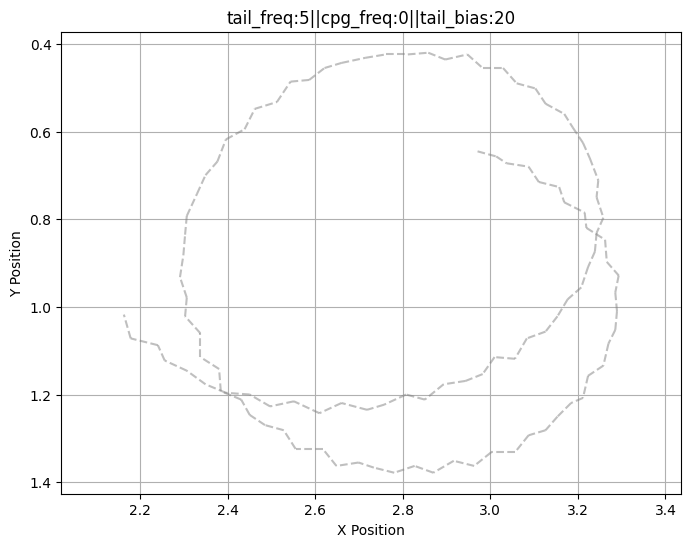

[np.float64(0.04092853177070204), np.float64(0.039206158110279256), np.float64(0.03943378928061451), np.float64(0.03878736600502279), np.float64(0.03819575740861582), np.float64(0.038139489426076284), np.float64(0.03509236088723809), np.float64(0.03410242548495999), np.float64(0.03428178120308466), np.float64(0.035497066468325573), np.float64(0.037694749354261314), np.float64(0.036376820192941146), np.float64(0.03394504769641536), np.float64(0.03369495681401261), np.float64(0.03370925710579037), np.float64(0.03616642363105842), np.float64(0.03647949206149499), np.float64(0.03484063373039115), np.float64(0.03379565856077409), np.float64(0.03283217893355075), np.float64(0.03399517769326137), np.float64(0.036158110142377416), np.float64(0.0335174769007293), np.float64(0.03260344762666357), np.float64(0.0323364344113799), np.float64(0.032352076870155295), np.float64(0.032814856675089994), np.float64(0.03439299395445141), np.float64(0.0321885657351413), np.float64(0.03272446445864356), np.f

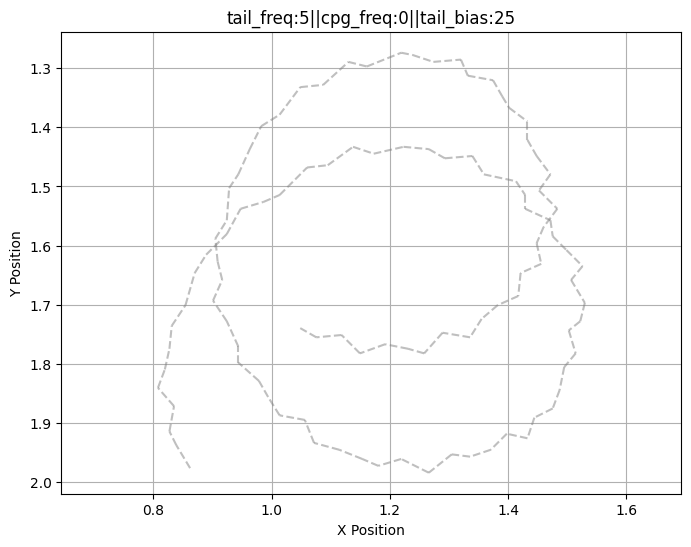

[np.float64(0.04889966105982118), np.float64(0.35529187634565695), np.float64(0.45159431909905656), np.float64(0.42916640571224574), np.float64(0.33442823400006383), np.float64(0.2638791458736661), np.float64(0.2700740841974197), np.float64(0.3642647466278115), np.float64(0.04906677629189399), np.float64(0.04634767378157819), np.float64(0.04623316486266326), np.float64(0.04531517391138039), np.float64(0.04824792149087434), np.float64(0.04927745021347343), np.float64(0.04986461785887751), np.float64(0.04952563595370953), np.float64(0.04734437949006228), np.float64(0.047722787988154644), np.float64(0.04867400971689156), np.float64(0.05881071281693196), np.float64(0.059443237256447824), np.float64(0.05565568064963279), np.float64(0.05232015586142693), np.float64(0.051811494734799526), np.float64(0.05388586774215743), np.float64(0.05679598134275253), np.float64(0.0572130464069058), np.float64(0.05617106556362421), np.float64(0.05318980956850536), np.float64(0.05207350596620568), np.float64

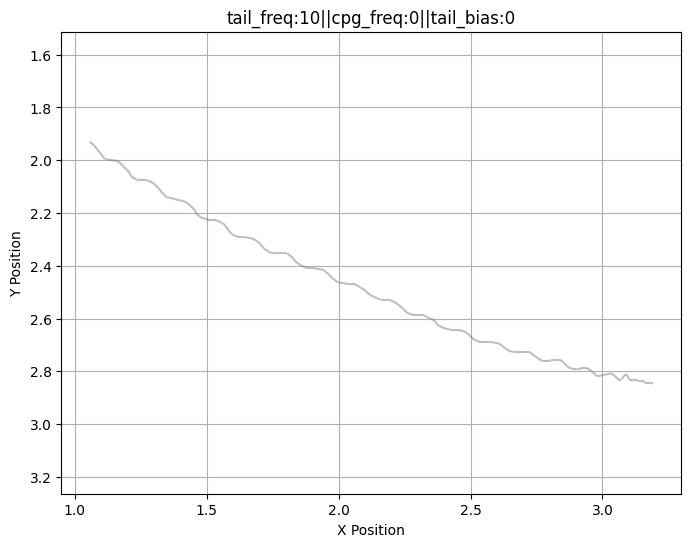

[np.float64(0.03841770063520541), np.float64(0.040739230092673176), np.float64(0.04411258313379433), np.float64(0.04779894685312674), np.float64(0.050933796211037), np.float64(0.05639886818459609), np.float64(0.06397448830420502), np.float64(0.06764731094140931), np.float64(0.07168008779113226), np.float64(0.07619870158718893), np.float64(0.080589238056988), np.float64(0.08591906398691058), np.float64(0.08879026443791892), np.float64(0.09006559215412999), np.float64(0.09439047230213683), np.float64(0.09696969919533541), np.float64(0.09943482224631242), np.float64(0.09941220927321853), np.float64(0.10260459244362288), np.float64(0.1051799422664797), np.float64(0.10518984164641153), np.float64(0.10698024360571437), np.float64(0.10973334335003114), np.float64(0.11140533033976038), np.float64(0.1109923129787688), np.float64(0.1124911220672014), np.float64(0.11414019843278696), np.float64(0.11496726961276277), np.float64(0.11505888470002866), np.float64(0.11757174779125733), np.float64(0.11

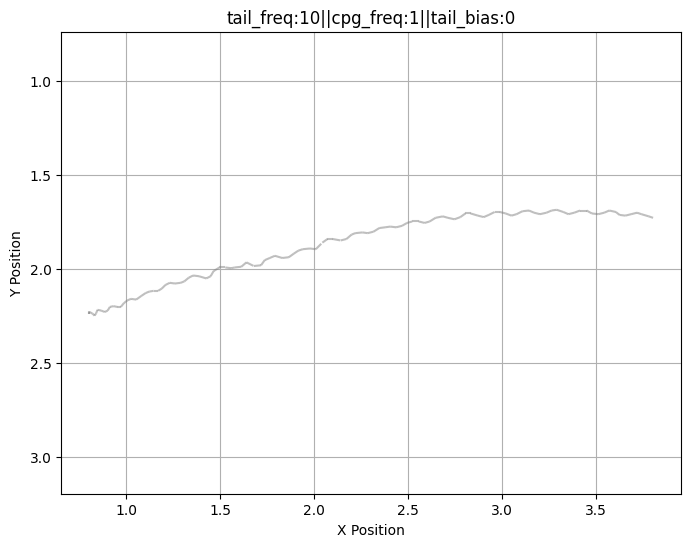

[np.float64(0.04397597110121193), np.float64(0.0625199587958396), np.float64(0.06708789633446154), np.float64(0.07105914306496058), np.float64(0.07523400482176226), np.float64(0.0799296364865937), np.float64(0.08391653971348945), np.float64(0.08780507410500249), np.float64(0.09156516477469533), np.float64(0.09283378375721722), np.float64(0.09585084163387181), np.float64(0.0987537182702681), np.float64(0.10141671843036654), np.float64(0.10329474897719439), np.float64(0.10545928047123374), np.float64(0.11055609870122309), np.float64(0.10901881186040664), np.float64(0.11160846786338731), np.float64(0.11542955701587058), np.float64(0.1175365002942816), np.float64(0.11873569570159251), np.float64(0.12100215729662812), np.float64(0.12168427218770667), np.float64(0.1256240506964227), np.float64(0.12668646522249846), np.float64(0.12588553561301788), np.float64(0.12476931500743782), np.float64(0.1283508461684148), np.float64(0.12928008754166123), np.float64(0.13100128089172292), np.float64(0.12

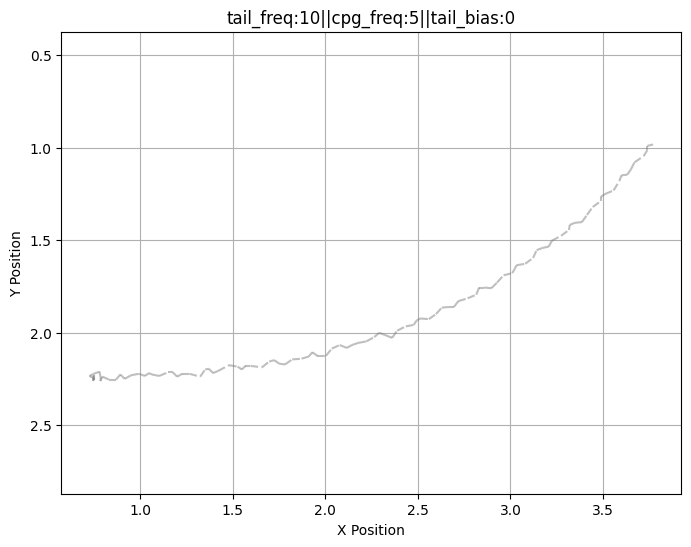

[np.float64(0.42434198912776044), np.float64(0.4572844607057757), np.float64(0.03848767634677408), np.float64(0.04271336796137073), np.float64(0.046056794012373566), np.float64(0.04698857538752324), np.float64(0.057146671738138845), np.float64(0.06603336635554272), np.float64(0.06613651556190392), np.float64(0.06304290311080839), np.float64(0.06324144478567935), np.float64(0.06314793506103425), np.float64(0.0716347754657697), np.float64(0.07676870177908071), np.float64(0.07705312519198781), np.float64(0.07498137793720397), np.float64(0.07117704454014274), np.float64(0.07132878538779966), np.float64(0.08040885225358403), np.float64(0.08723201237376677), np.float64(0.08859076141195345), np.float64(0.08430928092010605), np.float64(0.081556070468335), np.float64(0.08028561886284692), np.float64(0.0867261881988457), np.float64(0.09509881744437558), np.float64(0.09911527903249953), np.float64(0.09335533300624344), np.float64(0.09127148929459027), np.float64(0.09003197227321973), np.float64(0

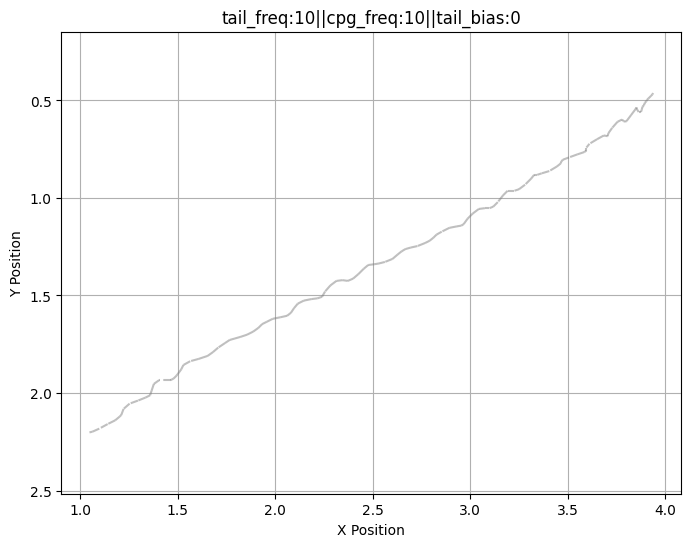

[np.float64(0.07251207389766114), np.float64(0.08378177148869548), np.float64(0.08645077137994632), np.float64(0.0910580072462736), np.float64(0.10387360313704133), np.float64(0.1094689687793123), np.float64(0.11236739585596266), np.float64(0.12612227584013172), np.float64(0.13580496143734225), np.float64(0.12940136658757698), np.float64(0.1325852809882507), np.float64(0.1401867249208607), np.float64(0.13930556221418322), np.float64(0.13681771762006656), np.float64(0.15034087284063577), np.float64(0.1462969141128824), np.float64(0.1418886532534022), np.float64(0.1548978102085196), np.float64(0.1536231864670908), np.float64(0.14631709470700174), np.float64(0.15750258083946303), np.float64(0.159883377824537), np.float64(0.1533225012062558), np.float64(0.15769442233897554), np.float64(0.16470368550980202), np.float64(0.15761004987743926), np.float64(0.15958096280323794), np.float64(0.16933395321218456), np.float64(0.1643792143188169), np.float64(0.1630182012515701), np.float64(0.169995724

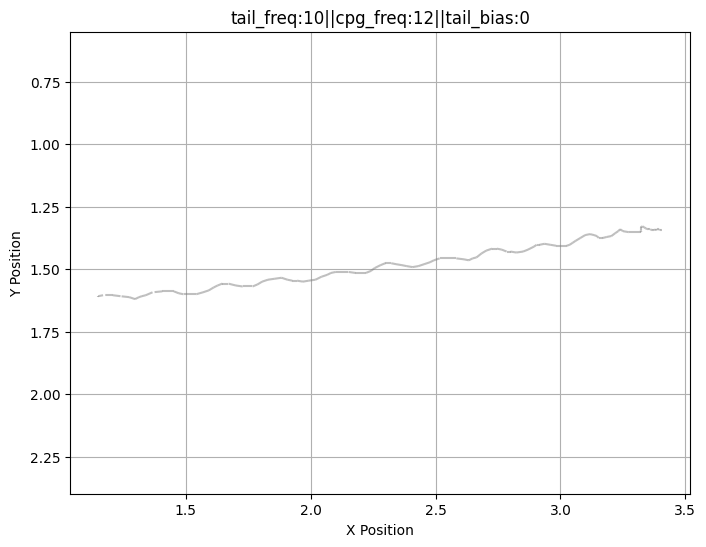

[np.float64(0.0778478158583325), np.float64(0.08767999077628785), np.float64(0.09224589362691951), np.float64(0.10483960952195197), np.float64(0.1215411940171443), np.float64(0.1288915770558268), np.float64(0.14160580596026143), np.float64(0.14237994875848875), np.float64(0.14775787303569574), np.float64(0.15688155741742885), np.float64(0.15704280154970368), np.float64(0.1650020051309692), np.float64(0.1668828955476869), np.float64(0.16892273433243313), np.float64(0.1738254212089183), np.float64(0.1728188780831909), np.float64(0.17393462153867076), np.float64(0.17914373217332838), np.float64(0.1769514693621497), np.float64(0.18114783809659485), np.float64(0.18202175952758567), np.float64(0.18175719485471487), np.float64(0.18679895175580638), np.float64(0.18364930912203553), np.float64(0.18503858240592988), np.float64(0.1862262132689118), np.float64(0.1844983098788481), np.float64(0.18784919802627323), np.float64(0.18758303658565223), np.float64(0.1882148206201174), np.float64(0.1947336

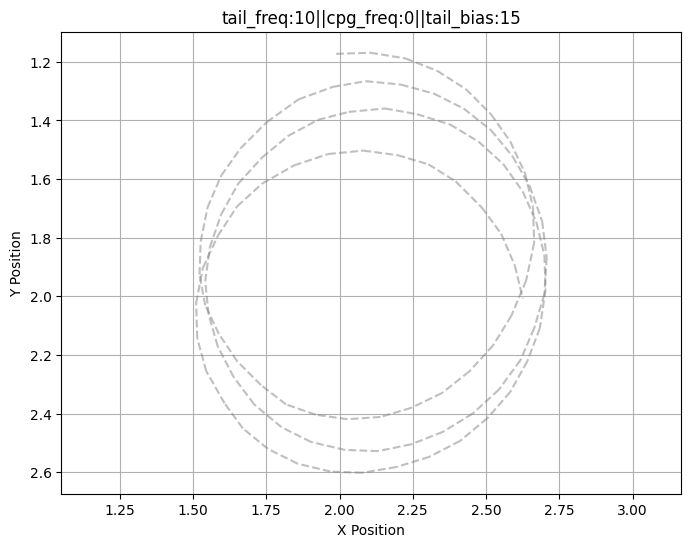

[np.float64(0.09835543477823433), np.float64(0.09797978899719093), np.float64(0.09679641958661526), np.float64(0.09789425753413929), np.float64(0.09903342973577679), np.float64(0.1004106465349913), np.float64(0.09799105991335454), np.float64(0.09643843272118494), np.float64(0.09815963924231577), np.float64(0.09906695487321632), np.float64(0.0973013535327294), np.float64(0.09657450527061194), np.float64(0.09852363643911674), np.float64(0.10049192301104666), np.float64(0.09795399623911304), np.float64(0.0968705614032136), np.float64(0.0997286834893379), np.float64(0.09905871443623487), np.float64(0.09815104188888037), np.float64(0.09627850916306023), np.float64(0.0988136301168145), np.float64(0.09961019572064882), np.float64(0.09767870219694749), np.float64(0.0972874398193839), np.float64(0.10011512601367399), np.float64(0.10172663511527952), np.float64(0.09941509890835262), np.float64(0.10024068796766604), np.float64(0.10139022039605226), np.float64(0.10075394021347152), np.float64(0.10

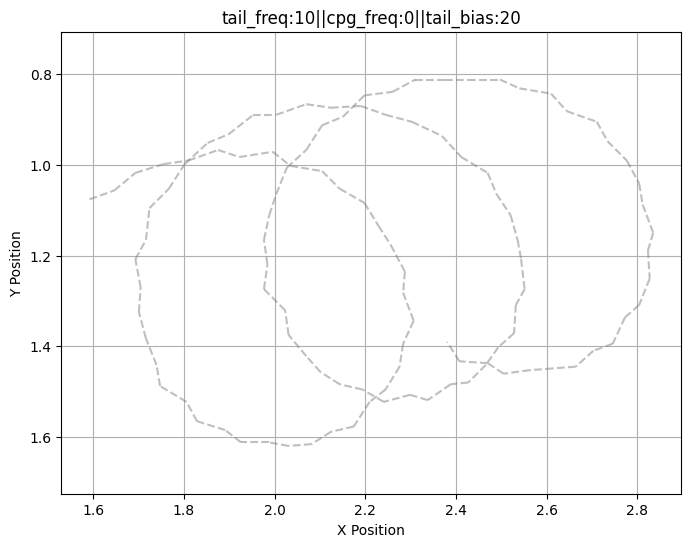

[np.float64(0.09275725861612372), np.float64(0.09278876346412929), np.float64(0.08974306543729256), np.float64(0.08841945170311834), np.float64(0.09091115552133022), np.float64(0.09177093482222923), np.float64(0.08965905794866197), np.float64(0.08769144042993995), np.float64(0.09000915314179044), np.float64(0.09108939257436251), np.float64(0.08841508318588996), np.float64(0.08655990716183727), np.float64(0.0892074500176926), np.float64(0.09094520490763497), np.float64(0.08668154207281019), np.float64(0.08522372875191836), np.float64(0.08684411677830212), np.float64(0.08801943279813569), np.float64(0.08408317736968701), np.float64(0.08312366602578099), np.float64(0.0851793809351699), np.float64(0.08522372223209088), np.float64(0.08172320544786055), np.float64(0.08199475790423603), np.float64(0.0825383635028302), np.float64(0.08262689384036397), np.float64(0.07962544506121254), np.float64(0.07822574329270292), np.float64(0.0786663363562973), np.float64(0.07728510124390867), np.float64(0.

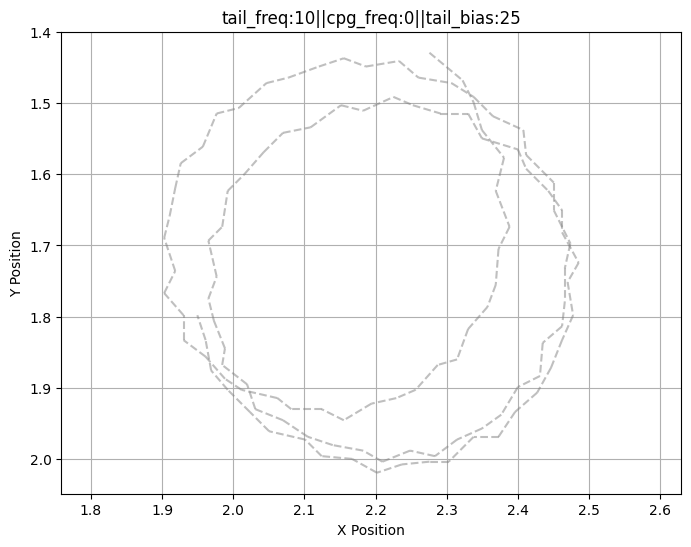

[np.float64(0.08501390890522395), np.float64(0.08353760345223239), np.float64(0.08256770128396898), np.float64(0.08404042439725437), np.float64(0.08127581245673958), np.float64(0.0808029576221489), np.float64(0.07982964938987785), np.float64(0.07979889275474865), np.float64(0.07899043066865814), np.float64(0.07679512386843923), np.float64(0.0770370560902332), np.float64(0.07705122786573637), np.float64(0.07465532412258315), np.float64(0.07271987815552594), np.float64(0.07388530291048263), np.float64(0.07347736392084227), np.float64(0.07199022961682117), np.float64(0.07181818787062899), np.float64(0.0725541265632731), np.float64(0.07344278869348869), np.float64(0.0702436225858692), np.float64(0.07063477669592323), np.float64(0.07067718125172141), np.float64(0.07043946794762303), np.float64(0.07039716842540121), np.float64(0.0693058506906768), np.float64(0.06903016068085208), np.float64(0.06976113951198977), np.float64(0.325384901902137), np.float64(0.338946219236656), np.float64(0.34847

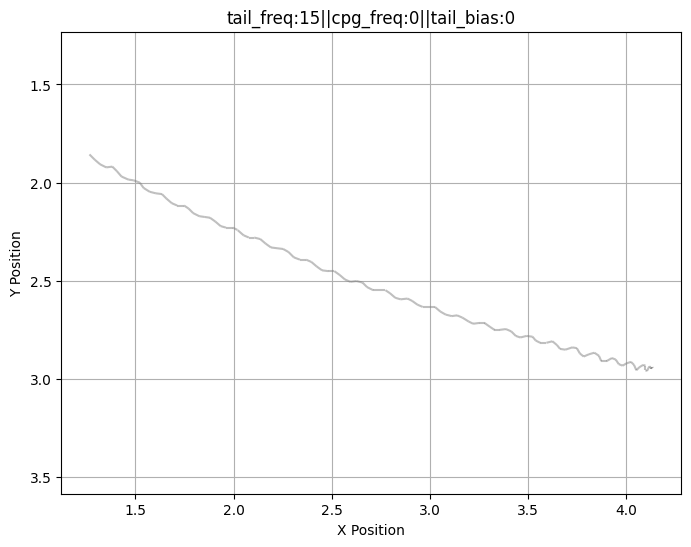

[np.float64(0.050057729702510996), np.float64(0.061465977821339134), np.float64(0.07950971559388342), np.float64(0.09737425012851116), np.float64(0.1088586720952018), np.float64(0.114158867402802), np.float64(0.12106192345073097), np.float64(0.12650570764510596), np.float64(0.12932157246969833), np.float64(0.1339745729520944), np.float64(0.13714872532007544), np.float64(0.14090631611927149), np.float64(0.14242250927626562), np.float64(0.1444351151621541), np.float64(0.14687841825389086), np.float64(0.14798935290806184), np.float64(0.15012736784176559), np.float64(0.15331521872286447), np.float64(0.1540688027110976), np.float64(0.15563906461797547), np.float64(0.15857599306977477), np.float64(0.15834731785886244), np.float64(0.16086253278403015), np.float64(0.1617271852989999), np.float64(0.16209098924643062), np.float64(0.1631993941186623), np.float64(0.16436244782452167), np.float64(0.165518594370213), np.float64(0.16605023485127546), np.float64(0.16814783149904633), np.float64(0.1670

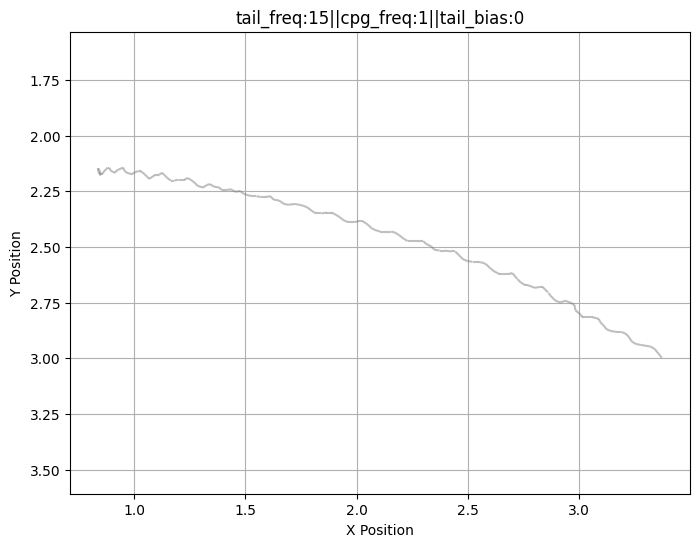

[np.float64(0.07493497866950544), np.float64(0.08700143981572689), np.float64(0.10493179675330064), np.float64(0.1141753200968946), np.float64(0.12010991543138354), np.float64(0.12678809138071773), np.float64(0.1329256430835101), np.float64(0.13887678570993353), np.float64(0.143946110034971), np.float64(0.14769089370174285), np.float64(0.15421852758359872), np.float64(0.15873074133026388), np.float64(0.16060989468041678), np.float64(0.16508800633451792), np.float64(0.16699869037103304), np.float64(0.16870467298801012), np.float64(0.17154752322150596), np.float64(0.1729850861601554), np.float64(0.1739050960546004), np.float64(0.1752516062184371), np.float64(0.1764359629862337), np.float64(0.17880920984215964), np.float64(0.17754768583706226), np.float64(0.17667254807322022), np.float64(0.18124252848476308), np.float64(0.1804050334851603), np.float64(0.180207421914416), np.float64(0.1801024031078206), np.float64(0.17959876422980375), np.float64(0.18017554642078487), np.float64(0.18074305

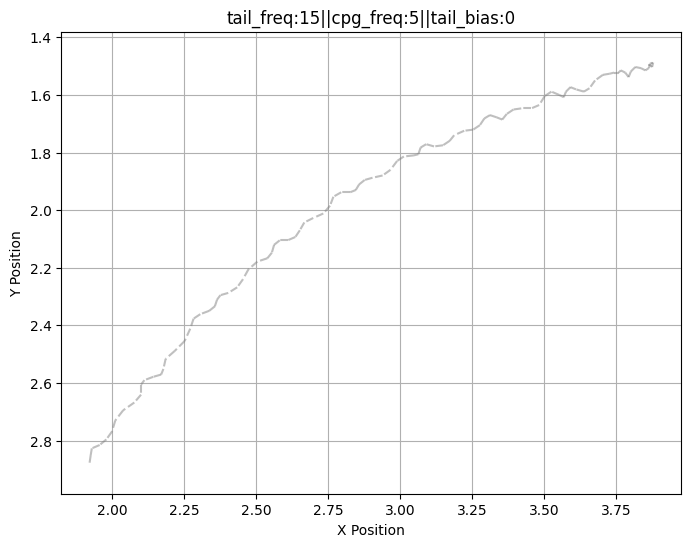

[np.float64(0.06867165576958817), np.float64(0.0759294862695799), np.float64(0.09550435328475348), np.float64(0.10558313767770808), np.float64(0.11038594814491341), np.float64(0.11392527464056224), np.float64(0.11285738814597929), np.float64(0.11859291186468401), np.float64(0.12449849326759689), np.float64(0.13095142950136093), np.float64(0.1345897260399401), np.float64(0.13472587620354068), np.float64(0.13270146061433483), np.float64(0.1320136816339131), np.float64(0.1350907831933889), np.float64(0.1418900191423179), np.float64(0.14623339653120943), np.float64(0.14559086843672453), np.float64(0.14324128544773693), np.float64(0.14122798239490383), np.float64(0.1445980061544646), np.float64(0.14818404092933612), np.float64(0.15398877409443346), np.float64(0.15587874171972363), np.float64(0.15178332888528903), np.float64(0.15090210947924346), np.float64(0.15014827344133336), np.float64(0.15305557519539023), np.float64(0.16003836196775825), np.float64(0.1638517382328015), np.float64(0.163

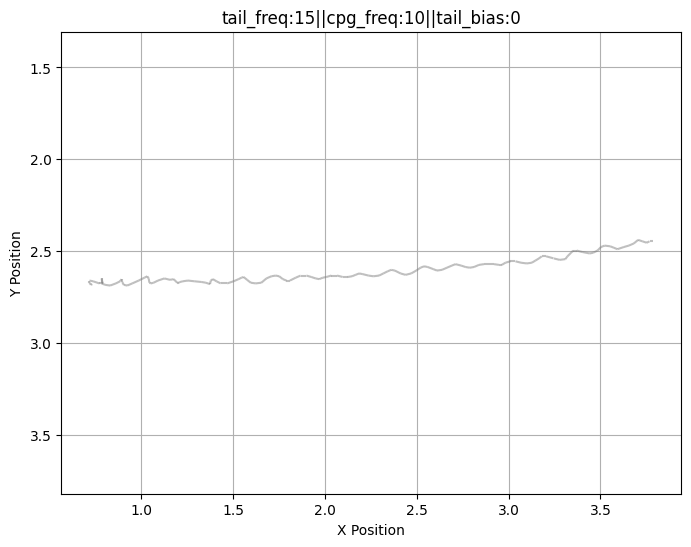

[np.float64(0.11587133108454988), np.float64(0.13539554465635825), np.float64(0.14777503963590877), np.float64(0.14356428287371722), np.float64(0.15407488329576405), np.float64(0.16853152031509805), np.float64(0.1607203335252025), np.float64(0.16694813697553862), np.float64(0.181266216719715), np.float64(0.17748486184805823), np.float64(0.1749968319500823), np.float64(0.18804561187938798), np.float64(0.19304570471082966), np.float64(0.18625350340638308), np.float64(0.19400966921517523), np.float64(0.20183299850160247), np.float64(0.1934352671109103), np.float64(0.19734349107047416), np.float64(0.20448040528978575), np.float64(0.19868969893950533), np.float64(0.20088656236782018), np.float64(0.20830120501250168), np.float64(0.20454395468130235), np.float64(0.20341559849837768), np.float64(0.2077438488451358), np.float64(0.20993885957885108), np.float64(0.20552945756775753), np.float64(0.2086284734607778), np.float64(0.21154446954785464), np.float64(0.206772610850523), np.float64(0.20784

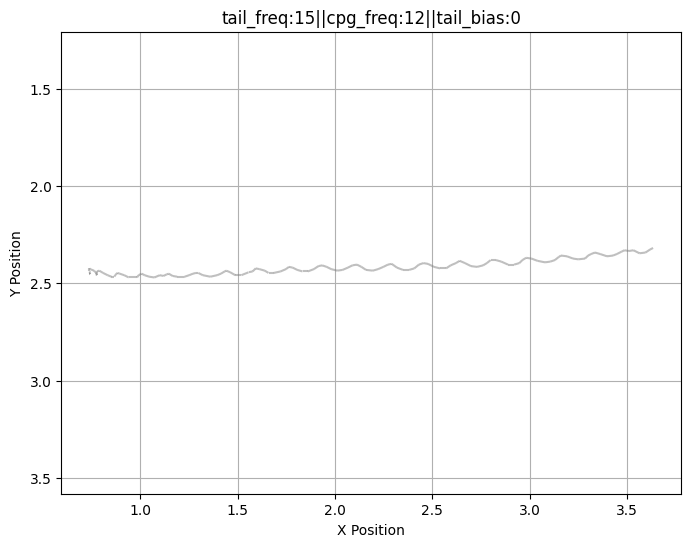

[np.float64(0.09628159463494997), np.float64(0.11532610934159902), np.float64(0.1301778239890146), np.float64(0.13965443250931986), np.float64(0.1522231477577251), np.float64(0.15137447888459638), np.float64(0.16681295811654137), np.float64(0.17437786462274613), np.float64(0.17409726747942814), np.float64(0.18446901443459293), np.float64(0.18574430182029383), np.float64(0.18670814278692416), np.float64(0.19743048319869297), np.float64(0.19374773594424577), np.float64(0.19738985701969838), np.float64(0.20269361179110526), np.float64(0.1994346235437631), np.float64(0.2070344142993087), np.float64(0.20587178193347078), np.float64(0.20460636826699513), np.float64(0.21348920825195303), np.float64(0.20904294585033129), np.float64(0.21288050933222297), np.float64(0.2166315144922377), np.float64(0.21331294481276314), np.float64(0.21854433288307304), np.float64(0.2179231658308115), np.float64(0.21704786786370897), np.float64(0.2224570754229986), np.float64(0.2196384738890976), np.float64(0.2228

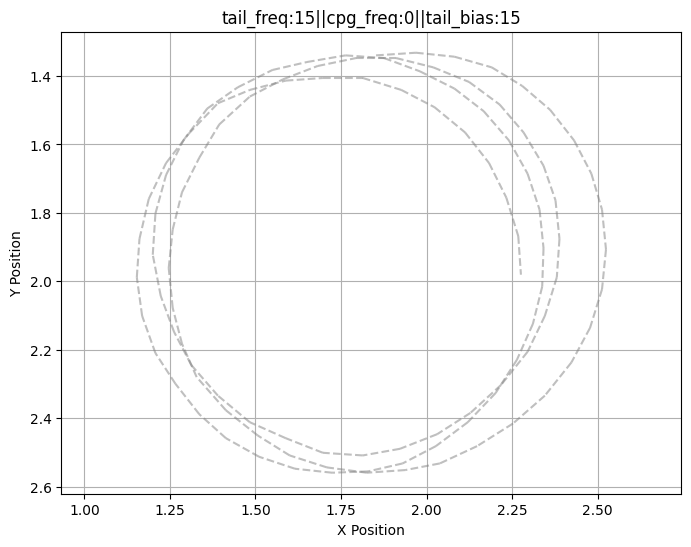

[np.float64(0.1407479995467986), np.float64(0.14074817905675777), np.float64(0.137177263808966), np.float64(0.13796734431106653), np.float64(0.1378429204475781), np.float64(0.13616788928225715), np.float64(0.13788147074015622), np.float64(0.13916832523424363), np.float64(0.13899742957903524), np.float64(0.14051031155527388), np.float64(0.13942709317764054), np.float64(0.1422195024575462), np.float64(0.14289019363430508), np.float64(0.14200322549522618), np.float64(0.14574768052896406), np.float64(0.14399288212444014), np.float64(0.1463096331733669), np.float64(0.14716131019365006), np.float64(0.14715863456699094), np.float64(0.14994879183831059), np.float64(0.1497260283275642), np.float64(0.1493655180167053), np.float64(0.15246371684425908), np.float64(0.15147040504663586), np.float64(0.15377841819468674), np.float64(0.15559697432014694), np.float64(0.15309484686183816), np.float64(0.15575587367997434), np.float64(0.15386697644063335), np.float64(0.15449966194247391), np.float64(0.1566

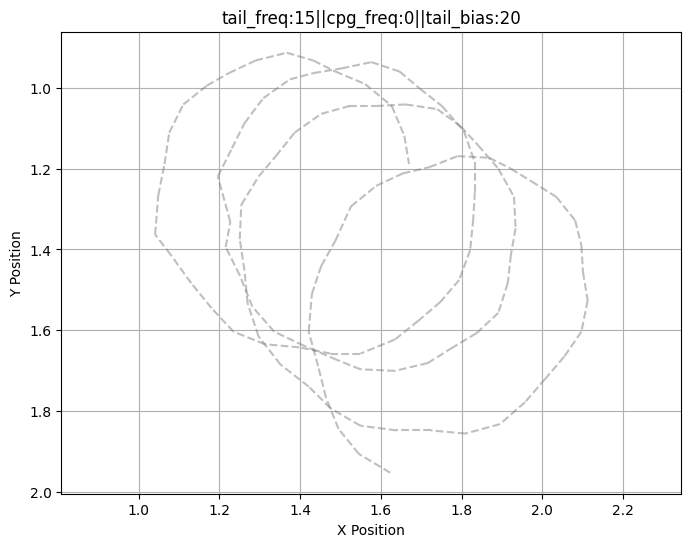

[np.float64(0.7639372627173614), np.float64(0.8012052037986646), np.float64(0.7726528204904513), np.float64(0.7843872414665843), np.float64(0.8009740810071667), np.float64(0.7702370922593738), np.float64(0.798992393960271), np.float64(0.779734042679767), np.float64(0.7511567795396901), np.float64(0.7565257143962089), np.float64(0.7169701288860669), np.float64(0.14810627158558773), np.float64(0.14064878992020813), np.float64(0.14504964739030946), np.float64(0.14231981011996264), np.float64(0.13683604138839345), np.float64(0.1294446265638423), np.float64(0.12400946150043572), np.float64(0.12262338398771969), np.float64(0.11907900943765526), np.float64(0.11434115225226896), np.float64(0.11569407585531226), np.float64(0.11364861854286339), np.float64(0.11275240837097782), np.float64(0.11502591212566982), np.float64(0.11107297327733355), np.float64(0.11367768628386221), np.float64(0.1152005094981898), np.float64(0.11110177892847316), np.float64(0.11489953175176215), np.float64(0.11489400173

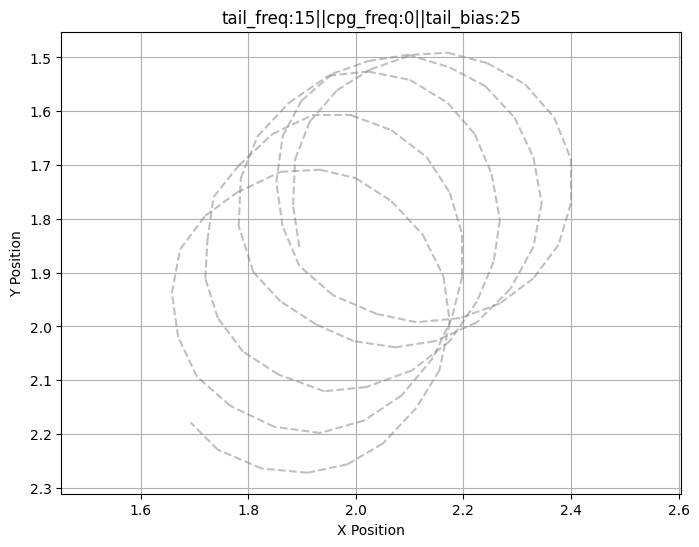

[np.float64(0.4863712370610138), np.float64(0.4886370932930265), np.float64(0.48273244950356275), np.float64(0.4704855766464867), np.float64(0.11043694892056341), np.float64(0.10635568372652217), np.float64(0.11114182478256861), np.float64(0.1090335654951144), np.float64(0.10787408534002789), np.float64(0.11151497155252206), np.float64(0.10740571742155298), np.float64(0.10836941244939659), np.float64(0.10913583498667499), np.float64(0.10694026099550673), np.float64(0.10755967631223572), np.float64(0.10830671373849408), np.float64(0.10823442532642483), np.float64(0.11116665028322012), np.float64(0.10722847813786533), np.float64(0.11150368755773388), np.float64(0.11180259098461226), np.float64(0.10916462883204135), np.float64(0.11420479310858904), np.float64(0.11087613590786775), np.float64(0.11176784809438832), np.float64(0.11480191978906855), np.float64(0.11004954484754989), np.float64(0.11316098998190463), np.float64(0.11320976853626928), np.float64(0.11247122370352856), np.float64(0.

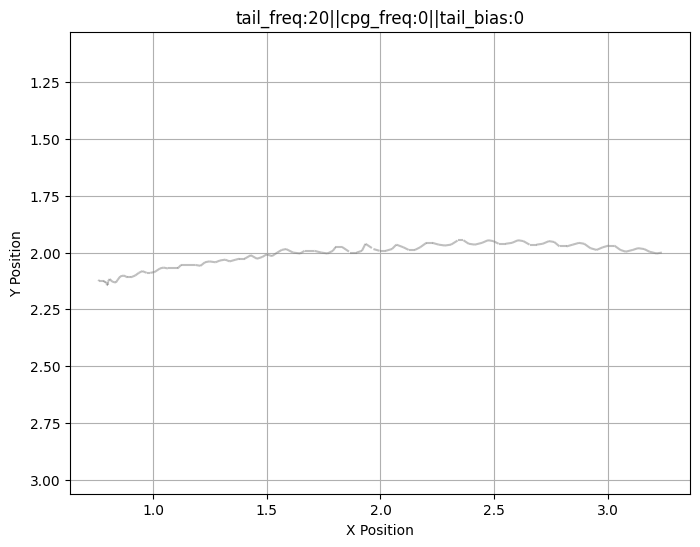

[np.float64(0.05434148313334562), np.float64(0.06565300960763829), np.float64(0.0839769091265497), np.float64(0.09854745977571562), np.float64(0.1369715589361015), np.float64(0.15506597600035124), np.float64(0.17122203688848042), np.float64(0.17286535415935286), np.float64(0.17792026061505067), np.float64(0.18127937699418298), np.float64(0.18572945600755367), np.float64(0.19548859368842422), np.float64(0.19831092500830827), np.float64(0.2005535343927603), np.float64(0.2048846697414635), np.float64(0.20787789155056247), np.float64(0.2069907462826427), np.float64(0.2121385119278021), np.float64(0.2145458838776658), np.float64(0.21820323988675766), np.float64(0.2185586529222413), np.float64(0.21839784492368675), np.float64(0.22161735258048967), np.float64(0.22063216870389682), np.float64(0.2239623788659226), np.float64(0.22095251914628683), np.float64(0.22074986130027735), np.float64(0.21987287827242158), np.float64(0.22146073611057968), np.float64(0.22256253063376144), np.float64(0.22277

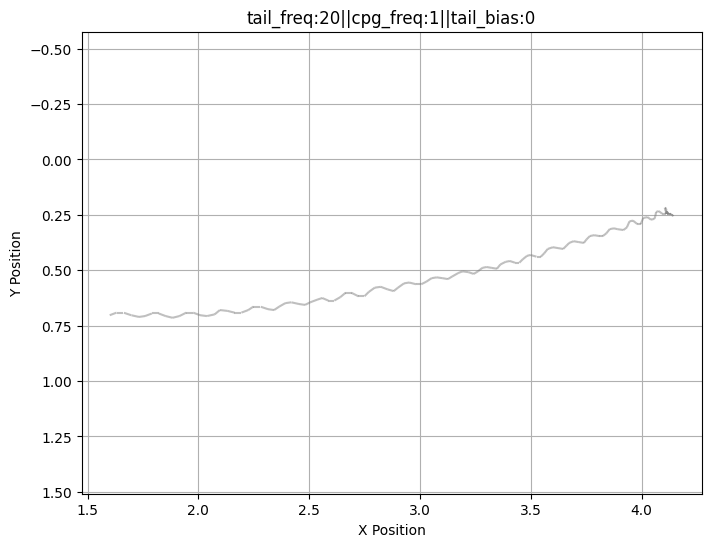

[np.float64(0.03396592674113695), np.float64(0.03643788907194469), np.float64(0.043364047998606964), np.float64(0.04517301844931985), np.float64(0.04728752490997735), np.float64(0.05533356189041643), np.float64(0.06688515187918838), np.float64(0.07498649074232154), np.float64(0.08636861041195194), np.float64(0.09534922233132048), np.float64(0.101498414675842), np.float64(0.10959434643480641), np.float64(0.11403770080461142), np.float64(0.12136958761269122), np.float64(0.13772215785339648), np.float64(0.14471563448528008), np.float64(0.14866153473630855), np.float64(0.15391174882854283), np.float64(0.15758706563586425), np.float64(0.16372061623769926), np.float64(0.16683939233492043), np.float64(0.1691426540849123), np.float64(0.17222184064374804), np.float64(0.17494107876566786), np.float64(0.1781677950799205), np.float64(0.1809769863802119), np.float64(0.18457254975531426), np.float64(0.1899251397284922), np.float64(0.19218846828794647), np.float64(0.1967047913642442), np.float64(0.20

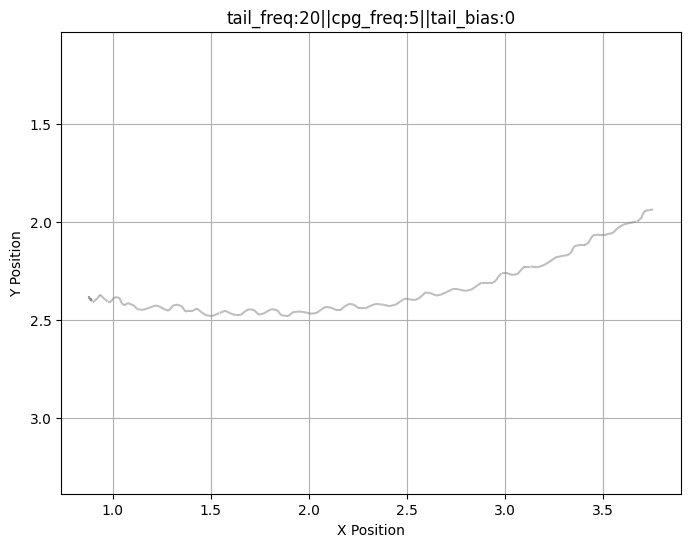

[np.float64(0.10805388841660013), np.float64(0.12773683985693218), np.float64(0.1544381466940249), np.float64(0.1665271801395701), np.float64(0.17582801041047197), np.float64(0.1831183018692075), np.float64(0.18271200293217865), np.float64(0.18946624953446786), np.float64(0.19727428499471297), np.float64(0.20686687798484624), np.float64(0.21169157542660308), np.float64(0.2088890345311051), np.float64(0.20659006120244489), np.float64(0.2080422423207576), np.float64(0.21140541854840608), np.float64(0.21937261716152415), np.float64(0.22337199488502474), np.float64(0.22053274116769947), np.float64(0.21554214005353844), np.float64(0.21489932294657324), np.float64(0.21650763733826545), np.float64(0.22194913877625053), np.float64(0.22731593816722792), np.float64(0.22522583875910682), np.float64(0.21944935390991435), np.float64(0.2184973526645846), np.float64(0.21776004962987652), np.float64(0.22059924371185807), np.float64(0.22646280594179052), np.float64(0.22777159061737284), np.float64(0.22

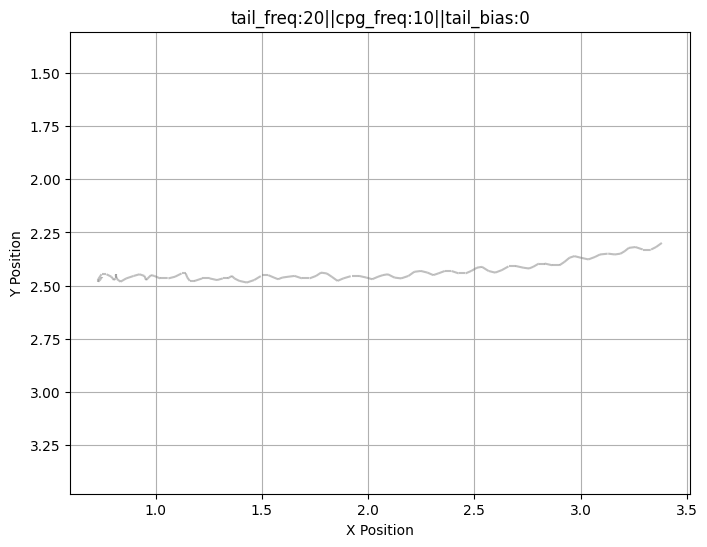

[np.float64(0.12659507391073932), np.float64(0.1549635710198687), np.float64(0.173762359474927), np.float64(0.18190351664708365), np.float64(0.1843713223429235), np.float64(0.20167673387168067), np.float64(0.2124355705319922), np.float64(0.20961637347434148), np.float64(0.21712221553954258), np.float64(0.22966816943172774), np.float64(0.2272102966109723), np.float64(0.22629769855098597), np.float64(0.23777278849963832), np.float64(0.2378340278688936), np.float64(0.23529663900149583), np.float64(0.24275881524632373), np.float64(0.24402872146679436), np.float64(0.23467890147525872), np.float64(0.24500694915102364), np.float64(0.24846183801724617), np.float64(0.24331094934233935), np.float64(0.24546577528621505), np.float64(0.2459630295121629), np.float64(0.24553512798534874), np.float64(0.24215865380039675), np.float64(0.24814545262131268), np.float64(0.24318668645880526)]
avg_stable_velocity_fowards: 0.24566606954005898
avg_stable_curvatures: 1812.8473156946175
avg_stable_omegas: 0.0158

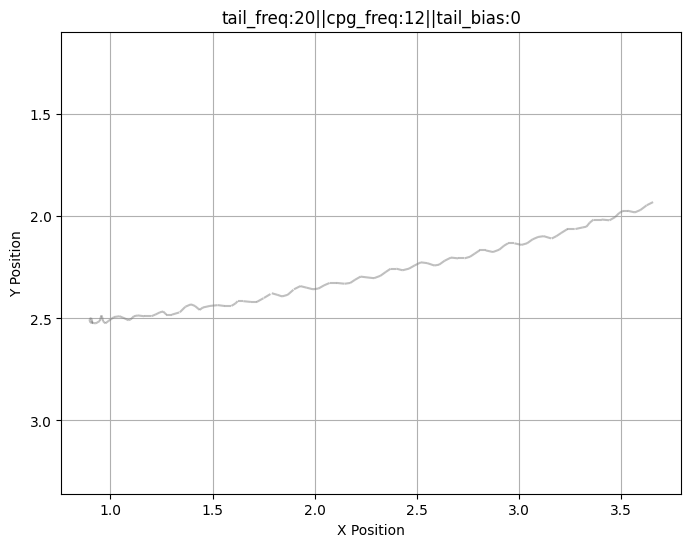

[np.float64(0.11347121727209343), np.float64(0.12497268906332298), np.float64(0.1398523166826978), np.float64(0.15884360223600089), np.float64(0.18649723175105626), np.float64(0.19442514877784917), np.float64(0.2040284775833005), np.float64(0.21811694237845927), np.float64(0.21886922913426057), np.float64(0.22465238747698604), np.float64(0.2338995305380355), np.float64(0.23243021257652383), np.float64(0.23892850835563978), np.float64(0.2415374549370018), np.float64(0.24020672102391255), np.float64(0.24701501409745688), np.float64(0.24433819286276853), np.float64(0.24610644796806264), np.float64(0.2510782316391285), np.float64(0.24787595570946444), np.float64(0.25041135231323847), np.float64(0.24937598458626148), np.float64(0.24791910273134804), np.float64(0.24911745364285073), np.float64(0.2478720580649797), np.float64(0.24887245394401983), np.float64(0.2478538068995714), np.float64(0.24313900990387868), np.float64(0.2477435678129281), np.float64(0.24321738379891047)]
avg_stable_veloci

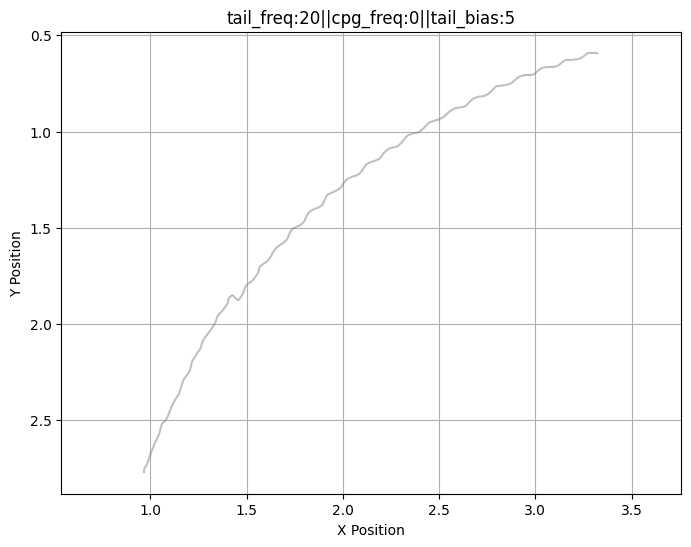

[np.float64(0.20716405020846568), np.float64(0.20987898610571257), np.float64(0.2125750978648987), np.float64(0.2118747005403865), np.float64(0.2129804035944545), np.float64(0.21277620318875587), np.float64(0.21224124789840182), np.float64(0.211949641867193), np.float64(0.21303263872422423), np.float64(0.2140587262688896), np.float64(0.21263222863672274), np.float64(0.21220636828085473), np.float64(0.21166698056452238), np.float64(0.21342889422459457), np.float64(0.21431927251030633), np.float64(0.21589468086618407), np.float64(0.2171012871553364), np.float64(0.21278045973049875), np.float64(0.21495659612251194), np.float64(0.21458103132476194), np.float64(0.21442836377760593), np.float64(0.21539885413076776), np.float64(0.2153435729675251), np.float64(0.21543022596290945), np.float64(0.2149272102170257), np.float64(0.21562602586561663), np.float64(0.21676348873182943), np.float64(0.21686003772869622), np.float64(0.21691187113656227), np.float64(0.21575252854778723), np.float64(0.21662

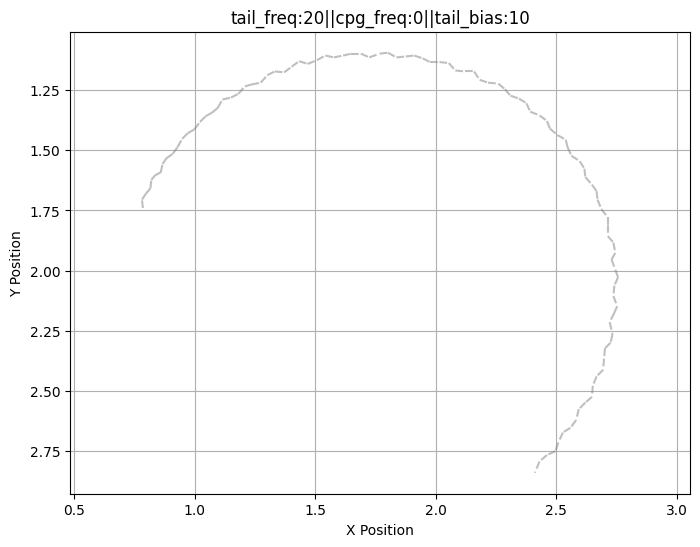

[np.float64(0.17949913840873577), np.float64(0.1822105683028812), np.float64(0.18454282529560098), np.float64(0.18641362134253395), np.float64(0.1911418320089992), np.float64(0.19380843010866977), np.float64(0.19610925457976178), np.float64(0.1963257635580671), np.float64(0.19699095365287453), np.float64(0.19869444274197756), np.float64(0.19975966255127153), np.float64(0.19968806284536836), np.float64(0.20180224695684587), np.float64(0.2007204160173149), np.float64(0.20208701820656352), np.float64(0.20284403886384655), np.float64(0.20321112008609216), np.float64(0.20309559984614428), np.float64(0.20323251209111987), np.float64(0.2024701766490036), np.float64(0.20450149846155366), np.float64(0.20191538312740553), np.float64(0.20146914255329607), np.float64(0.20040683661876008), np.float64(0.202045782381829), np.float64(0.2002289839310853), np.float64(0.20144409055360155), np.float64(0.19994478547526803), np.float64(0.20109668051814555), np.float64(0.20318555269587696), np.float64(0.2024

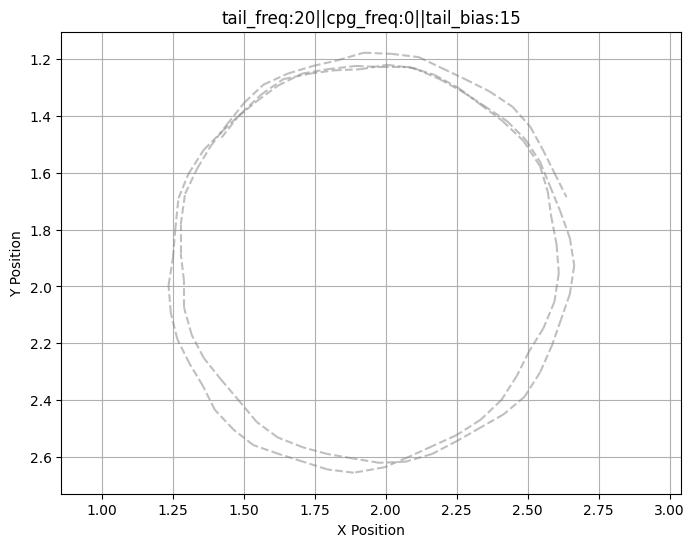

[np.float64(0.19826686956651393), np.float64(0.19476282181655408), np.float64(0.1954843635192696), np.float64(0.19607618925118453), np.float64(0.19813412121715057), np.float64(0.1977385081801839), np.float64(0.20016773318115696), np.float64(0.2016792355441221), np.float64(0.20281539146322214), np.float64(0.20097601156950945), np.float64(0.20194177915882688), np.float64(0.20119713418411042), np.float64(0.20287137600707497), np.float64(0.20271428744676778), np.float64(0.20402834333255812), np.float64(0.20387320524235905), np.float64(0.20396467589642842), np.float64(0.20436974687667356), np.float64(0.20480310980035074), np.float64(0.20446828508899104), np.float64(0.20511436874333733), np.float64(0.20361640364243164), np.float64(0.20391694973884664), np.float64(0.20530935336976722), np.float64(0.2042704275061104), np.float64(0.2058265948441851), np.float64(0.20653919176426658), np.float64(0.20614948738451147), np.float64(0.20531129919476357), np.float64(0.20495108635642834), np.float64(0.2

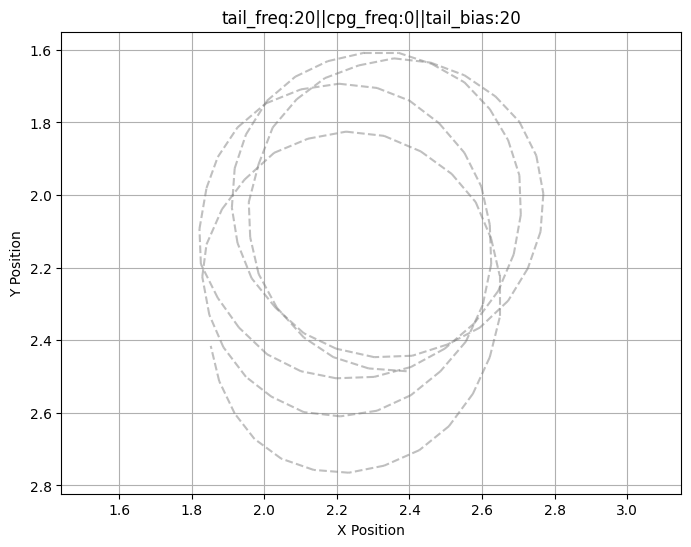

[np.float64(0.7554000253114782), np.float64(0.7499704288046996), np.float64(0.7679250804359989), np.float64(0.7697127140983074), np.float64(0.7952941369323708), np.float64(0.784012565555866), np.float64(0.7968748371907206), np.float64(0.7825529386682905), np.float64(0.790693642008444), np.float64(0.7724380767981153), np.float64(0.7715729780420201), np.float64(0.7489475898008376), np.float64(0.7503748069580126), np.float64(0.72761994988912), np.float64(0.1639424923426912), np.float64(0.16679004056862906), np.float64(0.16246871921625308), np.float64(0.16704452729090383), np.float64(0.16210229129574777), np.float64(0.16700452645859654), np.float64(0.16173172270914202), np.float64(0.16781471992859368), np.float64(0.16289881037057535), np.float64(0.16709494516207452), np.float64(0.16404839860786757), np.float64(0.16924515582822494), np.float64(0.16620411669323745), np.float64(0.17168849366811134), np.float64(0.16733572612716974), np.float64(0.17168980763313554), np.float64(0.168172886384798

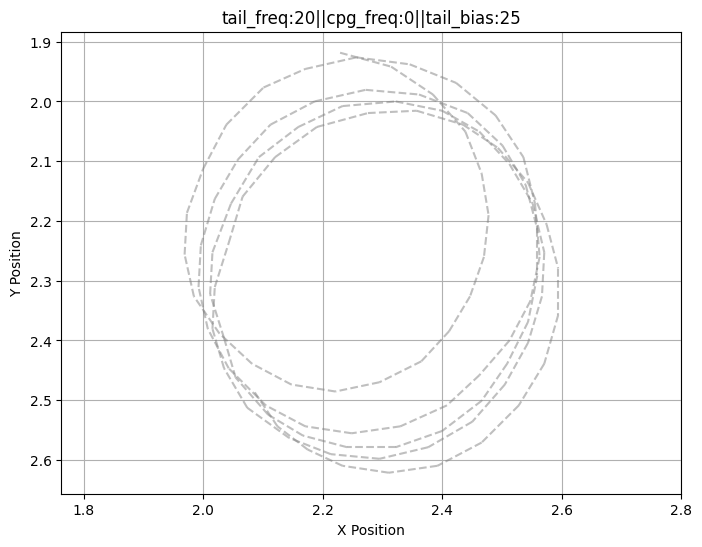

[np.float64(0.1412948556147037), np.float64(0.13785071738873142), np.float64(0.13785340319820713), np.float64(0.13739681896680075), np.float64(0.1354462684094656), np.float64(0.13537930449711547), np.float64(0.13465693524434605), np.float64(0.13629566062348134), np.float64(0.13432672631324075), np.float64(0.13482983166760554), np.float64(0.1321596095919196), np.float64(0.13448870214458564), np.float64(0.1339552098095962), np.float64(0.1343126522365705), np.float64(0.13451546245352933), np.float64(0.5030197107095066), np.float64(0.5003571230347071), np.float64(0.5129515251195771), np.float64(0.5040330668074314), np.float64(0.5092188586758403), np.float64(0.5029524678876471), np.float64(0.5215593700015005), np.float64(0.5171707806547675), np.float64(0.5240632420812704), np.float64(0.5211564136013528), np.float64(0.5391838266937969), np.float64(0.5344598918402553), np.float64(0.5424947322143159), np.float64(0.5474600876941997), np.float64(0.556207715825962), np.float64(0.1506574911272262)

In [10]:
folder_path = "/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data"#"./data"

# 使用glob获取所有csv文件路径
Tail_freq_list = [0, 5, 10, 15, 20]
Tail_biases_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
CPG_freq_list = [0, 1, 5, 10, 12]

for tail_freq in Tail_freq_list:
	for tail_bias in Tail_biases_list:
		for cpg_freq in CPG_freq_list:
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['tail_x'].diff().abs()>=1) |
						(df['tail_y'].diff().abs()>=1)) ]
				
				# df['head_x'] = df['head_x'] / 515 * 2
				# df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				# path_points_x = np.array(df['head_x'])
				# path_points_y = np.array(df['head_y'])
				# head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (tail_points) # + tail_points)/2
				
				# 绘制机器人的路径和方向（稀疏采样）
				fig, ax = plt.subplots(figsize=(8, 6))

				# 设置稀疏采样间隔
				sample_interval = int(len(timestamps)/100)  

				# 遍历采样后的点
				for i in range(0, len(tail_points), sample_interval):
					# head = head_points[i]
					tail = tail_points[i]
					
					# 计算机器人的朝向向量
					direction = tail  
					pos = tail 
					# 画出机器人的位置（箭头的起点）
					# ax.quiver(tail[0], tail[1], direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color='blue', headwidth=2)
					
					# 画出路径
					if i > 0:
						prev_pos = robot_points[i - sample_interval]
						ax.plot([prev_pos[0], pos[0]], [prev_pos[1], pos[1]], color='gray', linestyle='--', alpha=0.5)

				# # 设置图形参数
				ax.set_aspect('equal', 'box')
				ax.set_xlabel('X Position')
				ax.set_ylabel('Y Position')
				# 设置y轴的方向反转
				plt.gca().invert_yaxis()
				plt.axis('equal')
				plt.grid(True)
				plt.title("tail_freq:"+ str(tail_freq)+"||cpg_freq:" +  str(cpg_freq)+ "||tail_bias:"+str(tail_bias))
				plt.show()

				# 调用函数并打印结果
				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(tail_points, timestamps)
				# 输出结果
				print(velocity_fowards)
				print("avg_stable_velocity_fowards:", avg_stable_velocity_fowards)
				print("avg_stable_curvatures:", avg_stable_curvatures)
				print("avg_stable_omegas:", avg_stable_omegas)
				print("avg_stable_angles:", avg_stable_angles)

Cd_0x = 0.1445
Cd_1x = 0.1309
Cd_1y = 0.4098
Cd_2x = 0.1070
Cd_2y = 0.2273


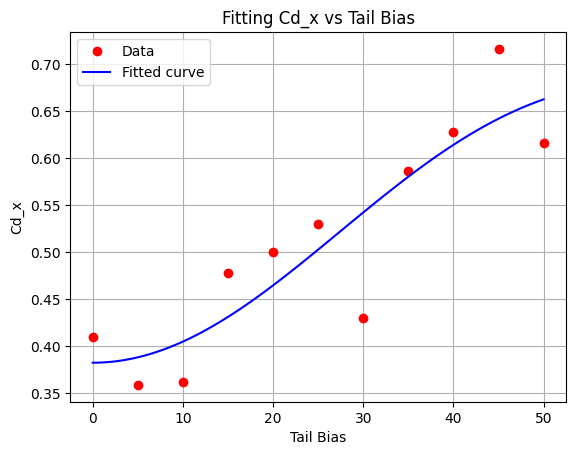

In [11]:

#  拟合系数 Cd_0x, Cd_1_x, Cd_1,y, Cd_2x, Cd_2y
# 使用glob获取所有csv文件路径
Tail_freq_list = [0]
Tail_biases_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
CPG_freq_list = [10]

Force_pec = [3.8]
Cd_xs = np.zeros(len(Tail_biases_list))
u_xs = np.zeros(len(Tail_biases_list))
for tail_freq in Tail_freq_list:
	for  tail_bias_id,tail_bias in enumerate(Tail_biases_list):
		for  cpg_freq_id, cpg_freq in enumerate(CPG_freq_list):
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				# print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['tail_x'].diff().abs()>=1) |
						(df['tail_y'].diff().abs()>=1)) ]
				
				# df['head_x'] = df['head_x'] / 515 * 2
				# df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				# path_points_x = np.array(df['head_x'])
				# path_points_y = np.array(df['head_y'])
				# head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (tail_points) # + tail_points)/2

				# 调用函数并打印结果
				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(tail_points, timestamps)

				Force = Force_pec[cpg_freq_id]
				Cd_xs[tail_bias_id] = Force / 500 / avg_stable_velocity_fowards**2
				u_xs[tail_bias_id] = avg_stable_velocity_fowards


# 拟合函数
def Cd_x_model(tail_bias, Cd_0x, Cd_1x, Cd_1y, Cd_2x, Cd_2y):
	return Cd_0x + Cd_1x * np.cos(np.radians(tail_bias))**2 + Cd_1y * np.sin(np.radians(tail_bias))**2 + \
		   Cd_2x * np.cos(2 * np.radians(tail_bias))**2+ Cd_2y * np.sin(2 * np.radians(tail_bias))**2

# 设置参数的上下限，确保参数为正值
lower_bounds = [0, 0, 0, 0, 0]  # 所有参数的下限为0，避免负值
upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]  # 上限为无穷大
# 使用curve_fit拟合
initial_guess = [1, 1,1, 1, 1]
params, covariance = curve_fit(Cd_x_model, Tail_biases_list, Cd_xs,  p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=100000)

# 提取拟合得到的参数
Cd_0x, Cd_1x, Cd_1y, Cd_2x, Cd_2y = params
print(f"Cd_0x = {Cd_0x:.4f}")
print(f"Cd_1x = {Cd_1x:.4f}")
print(f"Cd_1y = {Cd_1y:.4f}")
print(f"Cd_2x = {Cd_2x:.4f}")
print(f"Cd_2y = {Cd_2y:.4f}")

# 绘制拟合曲线
tail_bias_fine = np.linspace(0, 50, 100)  # 为了绘制光滑的曲线
Cd_x_fitted = Cd_x_model(tail_bias_fine, *params)

plt.plot(Tail_biases_list, Cd_xs, 'ro', label='Data')  # 原始数据
plt.plot(tail_bias_fine, Cd_x_fitted, 'b-', label='Fitted curve')  # 拟合曲线
plt.xlabel('Tail Bias')
plt.ylabel('Cd_x')
plt.legend()
plt.title('Fitting Cd_x vs Tail Bias')
plt.grid(True)
plt.show()

['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/5-0-0.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/5-0-15.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/5-0-20.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/5-0-25.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/10-0-0.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/10-0-15.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/10-0-20.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/10-0-25.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/15-0-0.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/data/15-0-15.csv']
['/Users/pengbin/Documents/snippet/BacksteppingMethod/multimodule_dynamic/dat

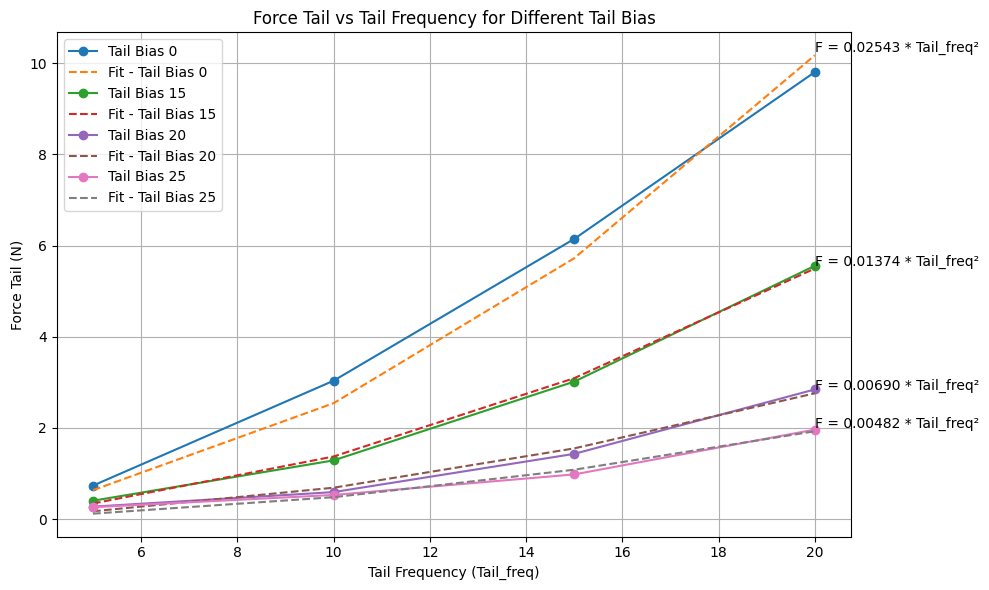

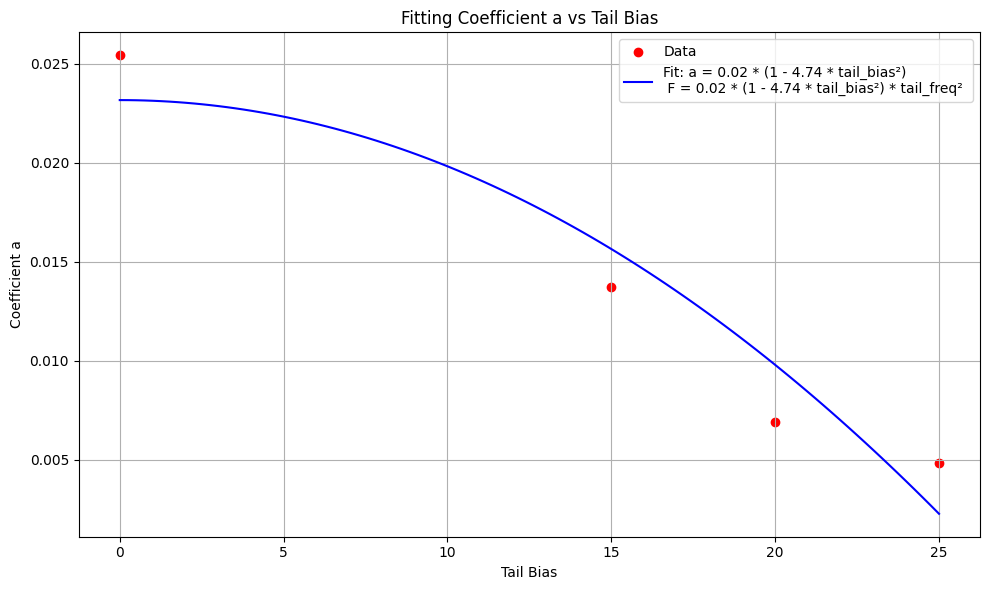

Fitted k1: 0.02317
Fitted k2: 4.73662


In [12]:

# 拟合 F_tail(Tail_freq, Tail_bias)

Tail_freq_list = [5, 10, 15, 20]
Tail_biases_list = [0, 15, 20, 25]
# CPG_freq_list = [0, 1, 5, 10, 12]
# Force_pec = [0, 0, 1.05, 3.8, 4.75]
CPG_freq_list = [ 0,]
Force_pec = [0]
Force_tail = np.zeros([len(Tail_freq_list), len(Tail_biases_list)])

for tail_freq_id, tail_freq in enumerate(Tail_freq_list):
	for  tail_bias_id,tail_bias in enumerate(Tail_biases_list):
		for  cpg_freq_id, cpg_freq in enumerate(CPG_freq_list):
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['head_x'].diff().abs()>=1) |
						(df['head_y'].diff().abs()>=1)) ]
				
				df['head_x'] = df['head_x'] / 515 * 2
				df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				path_points_x = np.array(df['head_x'])
				path_points_y = np.array(df['head_y'])
				head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (head_points) # + tail_points)/2

				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(head_points, timestamps)
				# print(avg_stable_velocity_fowards)
				
				Force_tail[tail_freq_id, tail_bias_id] = 500 * avg_stable_velocity_fowards**2 *Cd_xs[tail_bias_id]- Force_pec[cpg_freq_id]

# 绘制图形
plt.figure(figsize=(10, 6))

# 拟合函数
def fit_func(x, a):
	return a * x**2 

# 拟合 a 和 tail_bias 的关系 a = k1 * (1 - k2 * tail_bias^2)
def fit_a_relation(tail_bias, k1, k2):
    return k1 * (1 - k2 * (tail_bias*3.1415/180)**2)

ks = [] # k =  amp*2 * (a - b * bias^2)
# 绘制每个tail_bias的曲线，并拟合
for tail_bias_id, tail_bias in enumerate(Tail_biases_list):
	plt.plot(Tail_freq_list, Force_tail[:, tail_bias_id], 'o-', label=f"Tail Bias {tail_bias}")

	# 拟合数据
	params, _ = curve_fit(fit_func, Tail_freq_list, Force_tail[:, tail_bias_id])
	fitted_y = fit_func(np.array(Tail_freq_list), *params)

	# 绘制拟合曲线
	plt.plot(Tail_freq_list, fitted_y, '--', label=f"Fit - Tail Bias {tail_bias}")

	# 获取拟合参数
	a = params[0]
	equation = f"F = {a:.5f} * Tail_freq²"  # 显示拟合公式
	ks.append(a)

	# 在图形的最后一个点附近标注拟合公式
	plt.text(Tail_freq_list[-1], fitted_y[-1], equation, fontsize=10, verticalalignment='bottom', horizontalalignment='left')

# 图形参数设置
plt.xlabel("Tail Frequency (Tail_freq)")
plt.ylabel("Force Tail (N)")
plt.title("Force Tail vs Tail Frequency for Different Tail Bias")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 使用 curve_fit 对 a_vals 和 tail_bias_vals 进行拟合，得到 k1 和 k2
params_2, _ = curve_fit(fit_a_relation, Tail_biases_list, ks)
# 绘制拟合曲线
plt.figure(figsize=(10, 6))

# 绘制 a 与 tail_bias 的散点图
plt.scatter(Tail_biases_list, ks, label="Data", color='red')

# 绘制拟合曲线
tail_bias_range = np.linspace(min(Tail_biases_list), max(Tail_biases_list), 100)
fitted_ks = fit_a_relation(tail_bias_range, *params_2)
plt.plot(tail_bias_range, fitted_ks, label=f"Fit: a = {params_2[0]:.2f} * (1 - {params_2[1]:.2f} * tail_bias²) \n F = {params_2[0]:.2f} * (1 - {params_2[1]:.2f} * tail_bias²) * tail_freq² ", color='blue')

# 图形参数设置
plt.xlabel("Tail Bias")
plt.ylabel("Coefficient a")
plt.title("Fitting Coefficient a vs Tail Bias")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出拟合结果
k1, k2 = params_2
print(f"Fitted k1: {k1:.5f}")
print(f"Fitted k2: {k2:.5f}")

In [13]:
np.sqrt((Force_tail[1,0] + 3.8) / 500 / .42)

np.float64(0.18041945403710288)

In [14]:
Force_tail[1,0]

np.float64(3.035747672959718)

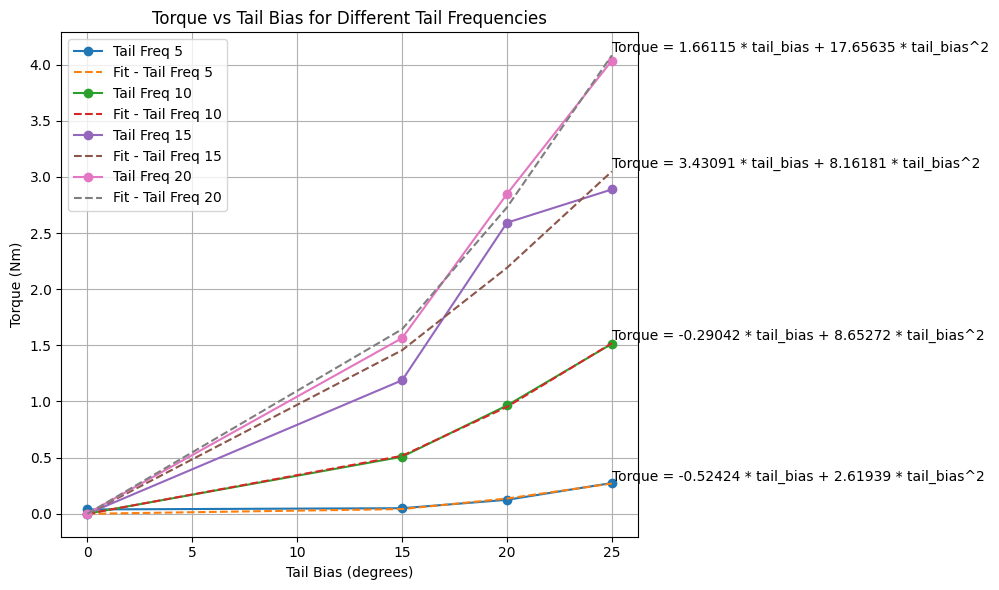

In [24]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 数据
Tail_freq_list = [5, 10, 15, 20]
Tail_biases_list = [0, 15, 20, 25]
CPG_freq_list = [0]
Force_pec = [0]
Force_tail = np.zeros([len(Tail_freq_list), len(Tail_biases_list)])
Torque_tail = np.zeros([len(Tail_freq_list), len(Tail_biases_list)])

# 计算Torque_tail
# def calculate_curvature_and_angles(head_points, timestamps):
#     avg_stable_velocity_fowards = np.random.rand()
#     avg_stable_omegas = np.random.rand()
#     return avg_stable_velocity_fowards, None, avg_stable_omegas, None, None, None, None, None, None

for tail_freq_id, tail_freq in enumerate(Tail_freq_list):
    for tail_bias_id, tail_bias in enumerate(Tail_biases_list):
        for cpg_freq_id, cpg_freq in enumerate(CPG_freq_list):
            csv_file = glob.glob(f"{folder_path}/{tail_freq}-{cpg_freq}-{tail_bias}.csv")
            if csv_file:
                df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
                df = df[((df['head_x'].diff().abs()>=1) | (df['head_y'].diff().abs()>=1)) ]
                
                df[['head_x', 'head_y', 'tail_x', 'tail_y']] /= 515 * 2
                
                head_points = df[['head_x', 'head_y']].values
                timestamps = df['timestamp'].values
                
                avg_stable_velocity_fowards, _, avg_stable_omegas, _, _, _, _, _, _ = calculate_curvature_and_angles(head_points, timestamps)
                
                Force_tail[tail_freq_id, tail_bias_id] = 500 * avg_stable_velocity_fowards**2 - Force_pec[cpg_freq_id]
                Torque_tail[tail_freq_id, tail_bias_id] = 5.76 * avg_stable_omegas**2
				

# 拟合 Torque 和 tail_bias 关系

def torque_fit_func(tail_bias, k1, k2):
    tail_bias = tail_bias*3.14/180
    return k1 * tail_bias + k2 * tail_bias**2

plt.figure(figsize=(10, 6))
ks = []

# 对每个 Tail_freq 进行拟合并绘图
for tail_freq_id, tail_freq in enumerate(Tail_freq_list):
    plt.plot(Tail_biases_list, Torque_tail[tail_freq_id, :], 'o-', label=f"Tail Freq {tail_freq}")
    
    params, _ = curve_fit(torque_fit_func, Tail_biases_list, Torque_tail[tail_freq_id, :])
    fitted_y = torque_fit_func(np.array(Tail_biases_list), *params)
    
    plt.plot(Tail_biases_list, fitted_y, '--', label=f"Fit - Tail Freq {tail_freq}")
    
    equation = f"Torque = {params[0]:.5f} * tail_bias + {params[1]:.5f} * tail_bias^2"
    ks.append(params)
    plt.text(Tail_biases_list[-1], fitted_y[-1], equation, fontsize=10, verticalalignment='bottom', horizontalalignment='left')

plt.xlabel("Tail Bias (degrees)")
plt.ylabel("Torque (Nm)")
plt.title("Torque vs Tail Bias for Different Tail Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
